In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
import seaborn as sns
import os

import cv2

from glob import glob
from matplotlib.patches import  Polygon
from matplotlib.collections import PatchCollection
from scipy.stats import linregress, f_oneway
from scipy.spatial.distance import cdist
from scipy.linalg import polar


import sys
sys.path.insert(0, "..")

from utils import geometry

In [2]:
save_dir='C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Movies_to_track\\Output\\comparison_plots/'

out_folder='C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Movies_to_track\\Output/'

### Data for all cells

In [3]:
cell_data=pd.read_csv(out_folder+'/long_tracked_cell_data_pooled.csv')


### Data by time and experiment

In [80]:
exp_time_data=cell_data.groupby(['experiment', 'time']).cell_area_microns.sum().to_frame(name='total_area')
exp_time_data=exp_time_data.merge(cell_data.groupby(['experiment', 'time']).cell_id_new.count(), on=['experiment', 'time'])
exp_time_data=exp_time_data.rename(columns={'cell_id_new':'cell_count'}).reset_index()
exp_time_data=exp_time_data.merge(cell_data[['experiment', 'stretch_type']].drop_duplicates(),how='left', on='experiment')
exp_time_data['cell_density']=exp_time_data.cell_count/exp_time_data.total_area
exp_time_data['mean_area_per_cell']=exp_time_data.total_area/exp_time_data.cell_count



### Data at the experiment level

In [81]:
exp_data=exp_time_data.groupby('experiment').first().reset_index()
exp_data=exp_data.rename(columns={'total_area':'initial_total_area', 'cell_count':'initial_cell_count', 'cell_density':'initial_cell_density',
       'mean_area_per_cell':'initial_mean_area_per_cell'})

exp_data['number_of_divisions']=cell_data[(cell_data.time==0)&(cell_data.state=='will divide')].groupby('experiment').count().cell_id_new.values
exp_data['experiment_length']=cell_data.groupby('experiment').time.max().values
exp_data['division_rate']=exp_data.number_of_divisions/exp_data.experiment_length
exp_data['div_number_norm']=exp_data.number_of_divisions/exp_data.initial_cell_count
exp_data['div_number_norm_rate']=exp_data.div_number_norm/exp_data.experiment_length
exp_data['div_amount'] =np.where(exp_data.div_number_norm_rate>0.001, 'high', 'low')




In [82]:
cell_data=cell_data.merge(exp_data[['experiment', 'div_amount']], on='experiment')
exp_time_data=exp_time_data.merge(exp_data[['experiment', 'div_amount']], on='experiment')


In [83]:
exp_time_data['total_area_norm']=exp_time_data.total_area/exp_time_data.groupby(['experiment']).total_area.transform('first')

exp_time_data['x_scale']=1
exp_time_data['y_scale']=1

for exp in np.unique(exp_time_data.experiment):
    dat_df=cell_data[cell_data.experiment==exp]
    Fx=[1]
    Fy=[1]

    for i in range(dat_df.tm_frame.max()):

        cc_i=dat_df[dat_df.tm_frame==i][['cell_id_new','cc_x', 'cc_y', 'tm_frame']]
        cc_f=dat_df[dat_df.tm_frame==i+1][['cell_id_new','cc_x', 'cc_y', 'tm_frame']]
        cc_diff=pd.merge(cc_i, cc_f, on='cell_id_new', suffixes=("_i", "_f"), how='inner')
        cc_diff
        aft=np.array(cv2.estimateAffine2D(cc_diff[['cc_x_i', 'cc_y_i']].values, cc_diff[['cc_x_f', 'cc_y_f']].values, method=cv2.RANSAC)[0][:,:2])
        Fx.append(polar(aft)[1][0,0])
        Fy.append(polar(aft)[1][1,1])

    exp_time_data.loc[exp_time_data.experiment==exp, 'x_scale']=np.cumprod(Fx)
    exp_time_data.loc[exp_time_data.experiment==exp, 'y_scale']=np.cumprod(Fy)


In [84]:
d_centres=cell_data[cell_data.state=='daughter cell'].groupby(['experiment','parent_id', 'cell_id_new']).first()[['cc_x', 'cc_y', 'stretch_type', 'first_frame']].reset_index()
d_centres['dx']=d_centres.groupby(['experiment', 'parent_id']).cc_x.transform('diff')
d_centres['dy']=d_centres.groupby(['experiment', 'parent_id']).cc_y.transform('diff')
d_dists=d_centres.groupby(['stretch_type','experiment', 'parent_id', 'first_frame']).sum()[['dx','dy']].reset_index()
d_dists['dr']=np.sqrt(d_dists.dx**2+d_dists.dy**2)
d_dists['div_angle']=np.arctan2(d_dists.dy/d_dists.dr, d_dists.dx/d_dists.dr)

d_dists['div_angle']=np.where(d_dists.div_angle<0, d_dists.div_angle+np.pi, d_dists.div_angle)

d_dists['div_angle_horizontal']=abs(np.where(d_dists.div_angle<np.pi/2,d_dists.div_angle, d_dists.div_angle-np.pi))

In [86]:
d_dists=d_dists.merge(exp_data[['experiment', 'div_amount']], on='experiment')



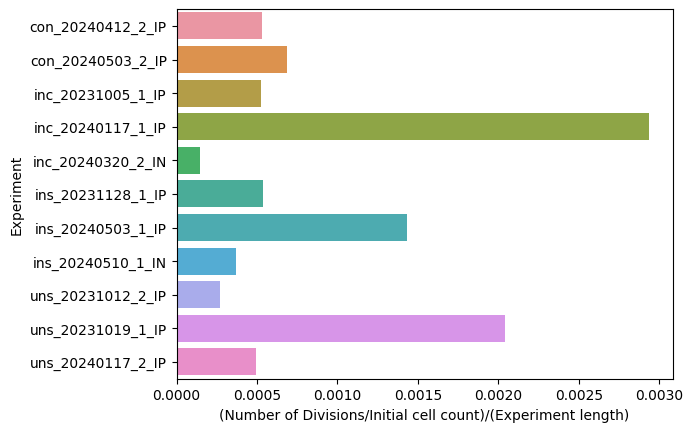

In [355]:
fig, ax=plt.subplots()
g = sns.barplot(
    data=exp_data,ax=ax, y="experiment", x="div_number_norm_rate")
ax.set_ylabel('Experiment')
ax.set_xlabel('(Number of Divisions/Initial cell count)/(Experiment length)')
plt.savefig(save_dir+'/div_rate.png', dpi=300, bbox_inches='tight')


C:\Users\v35431nc\AppData\Local\Temp\ipykernel_33796\876182195.py:3: UserWarning: The palette list has more values (33) than needed (23), which may not be intended.
  g=sns.scatterplot(cell_data[(cell_data.time==0)&(cell_data.stretch_type=='f')&(cell_data.state=='will divide')], x='area_norm_mean', y='circularity', ax=ax[0,0],s=8, hue='last_frame', palette=sns.color_palette("rainbow",33), legend=False)
C:\Users\v35431nc\AppData\Local\Temp\ipykernel_33796\876182195.py:7: UserWarning: 
The palette list has fewer values (33) than needed (34) and will cycle, which may produce an uninterpretable plot.
  g=sns.scatterplot(cell_data[(cell_data.time==0)&(cell_data.stretch_type=='s')&(cell_data.state=='will divide')], x='area_norm_mean', y='circularity', ax=ax[0,1],s=8, hue='last_frame', palette=sns.color_palette("rainbow",33), legend=False)
C:\Users\v35431nc\AppData\Local\Temp\ipykernel_33796\876182195.py:12: UserWarning: The palette list has more values (33) than needed (26), which may not be

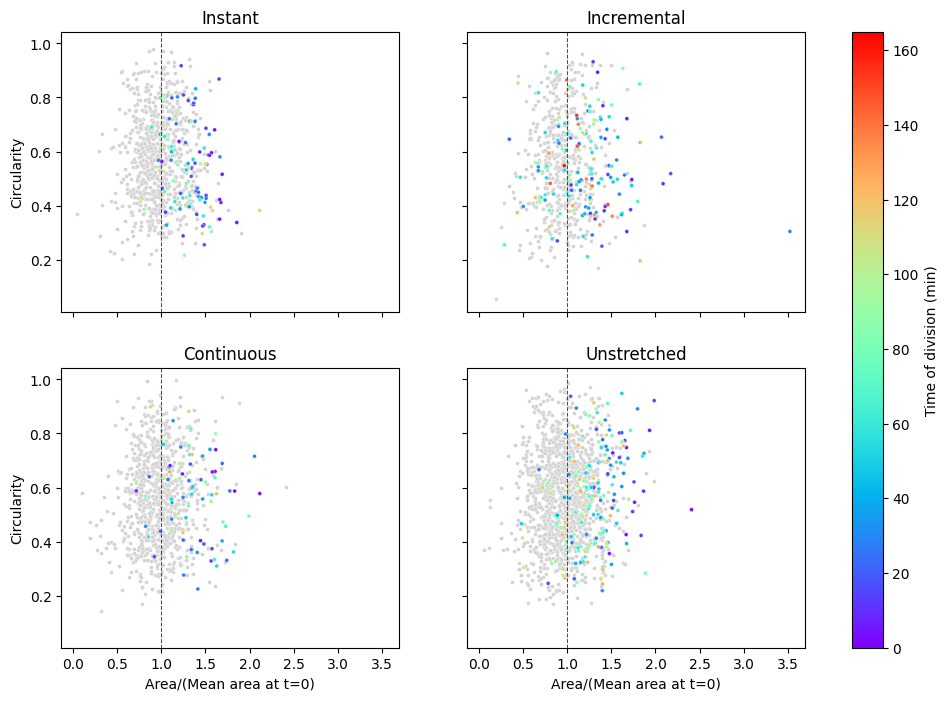

In [356]:
fig, ax=plt.subplots(2,2, sharey=True, sharex=True, figsize=(12,8))
sns.scatterplot(cell_data[(cell_data.time==0)&(cell_data.stretch_type=='f')&(cell_data.state=='never divides')], x='area_norm_mean', y='circularity', ax=ax[0,0],s=8, c='lightgrey')
g=sns.scatterplot(cell_data[(cell_data.time==0)&(cell_data.stretch_type=='f')&(cell_data.state=='will divide')], x='area_norm_mean', y='circularity', ax=ax[0,0],s=8, hue='last_frame', palette=sns.color_palette("rainbow",33), legend=False)
ax[0,0].set_title("Instant")

sns.scatterplot(cell_data[(cell_data.time==0)&(cell_data.stretch_type=='s')&(cell_data.state=='never divides')], x='area_norm_mean', y='circularity', ax=ax[0,1],s=8, c='lightgrey')
g=sns.scatterplot(cell_data[(cell_data.time==0)&(cell_data.stretch_type=='s')&(cell_data.state=='will divide')], x='area_norm_mean', y='circularity', ax=ax[0,1],s=8, hue='last_frame', palette=sns.color_palette("rainbow",33), legend=False)
ax[0,1].set_title("Incremental")


sns.scatterplot(cell_data[(cell_data.time==0)&(cell_data.stretch_type=='c')&(cell_data.state=='never divides')], x='area_norm_mean', y='circularity', ax=ax[1,0], s=8, c='lightgrey')
g=sns.scatterplot(cell_data[(cell_data.time==0)&(cell_data.stretch_type=='c')&(cell_data.state=='will divide')], x='area_norm_mean', y='circularity', ax=ax[1,0],s=8, hue='last_frame', palette=sns.color_palette("rainbow",33), legend=False)
ax[1,0].set_title("Continuous")


sns.scatterplot(cell_data[(cell_data.time==0)&(cell_data.stretch_type=='u')&(cell_data.state=='never divides')], x='area_norm_mean', y='circularity', ax=ax[1,1], s=8, c='lightgrey')
g=sns.scatterplot(cell_data[(cell_data.time==0)&(cell_data.stretch_type=='u')&(cell_data.state=='will divide')], x='area_norm_mean', y='circularity', ax=ax[1,1],s=8, hue='last_frame', palette=sns.color_palette("rainbow",33), legend=False)
ax[1,1].set_title("Unstretched")

ax[0,0].axvline(1, linestyle='--', linewidth=0.75, c='red')
ax[0,1].axvline(1, linestyle='--', linewidth=0.75, c='red')
ax[1,0].axvline(1, linestyle='--', linewidth=0.75, c='red')
ax[1,1].axvline(1, linestyle='--', linewidth=0.75, c='red')

ax[1,0].set_xlabel("Area/(Mean area at t=0)")
ax[1,1].set_xlabel("Area/(Mean area at t=0)")

ax[1,0].set_ylabel("Circularity")
ax[0,0].set_ylabel("Circularity")


cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(0, 33*5), cmap='rainbow'),
             ax=ax, orientation='vertical', label='Time of division (min)')
#cbar.ax.set_ylabel('angle', rotation=90)
plt.savefig(save_dir+'/t_0_cells_area_circ.png', dpi=300, bbox_inches='tight')

In [23]:
cell_data.columns

Index(['index', 'cell_id_old', 'cell_perimeter_microns', 'cell_area_microns',
       'shape_parameter', 'circularity', 'cell_edge_count',
       'major_shape_axis_alignment_rads', 'cc_x', 'cc_y', 'cell_id_new',
       'spot_id', 'time', 'tm_frame', 'cell_perimeter_nd', 'cell_area_nd',
       'cell_P_eff_nd', 'cell_shear', 'cell_zeta',
       'major_stress_axis_alignment_rads', 'parent_id', 'divisions',
       'angle_horizontal', 'circ_J', 'circ_P', 'circ_A', 'shape_axis_J',
       'shape_axis_P', 'shape_axis_A', 'nn_order', 'nn_order_2', 'order_all',
       'mean_cc_distance', 'mean_cc_distance_2', 'experiment', 'stretch_type',
       'state', 'area_norm', 'perimeter_norm', 'first_frame', 'last_frame',
       'area_norm_mean', 'area_norm_last', 'circ_norm', 'circ_norm_last',
       'aligned_time', 'aligned_time_back', 'div_amount'],
      dtype='object')

In [13]:
high_div=cell_data[cell_data.experiment.isin(["ins_20240503_1_IP", "inc_20240117_1_IP", "uns_20231019_1_IP"])]
low_div=cell_data[~cell_data.experiment.isin(["ins_20240503_1_IP", "inc_20240117_1_IP", "uns_20231019_1_IP"])]

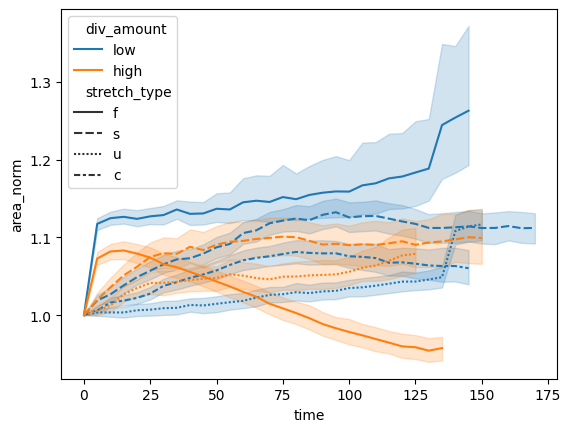

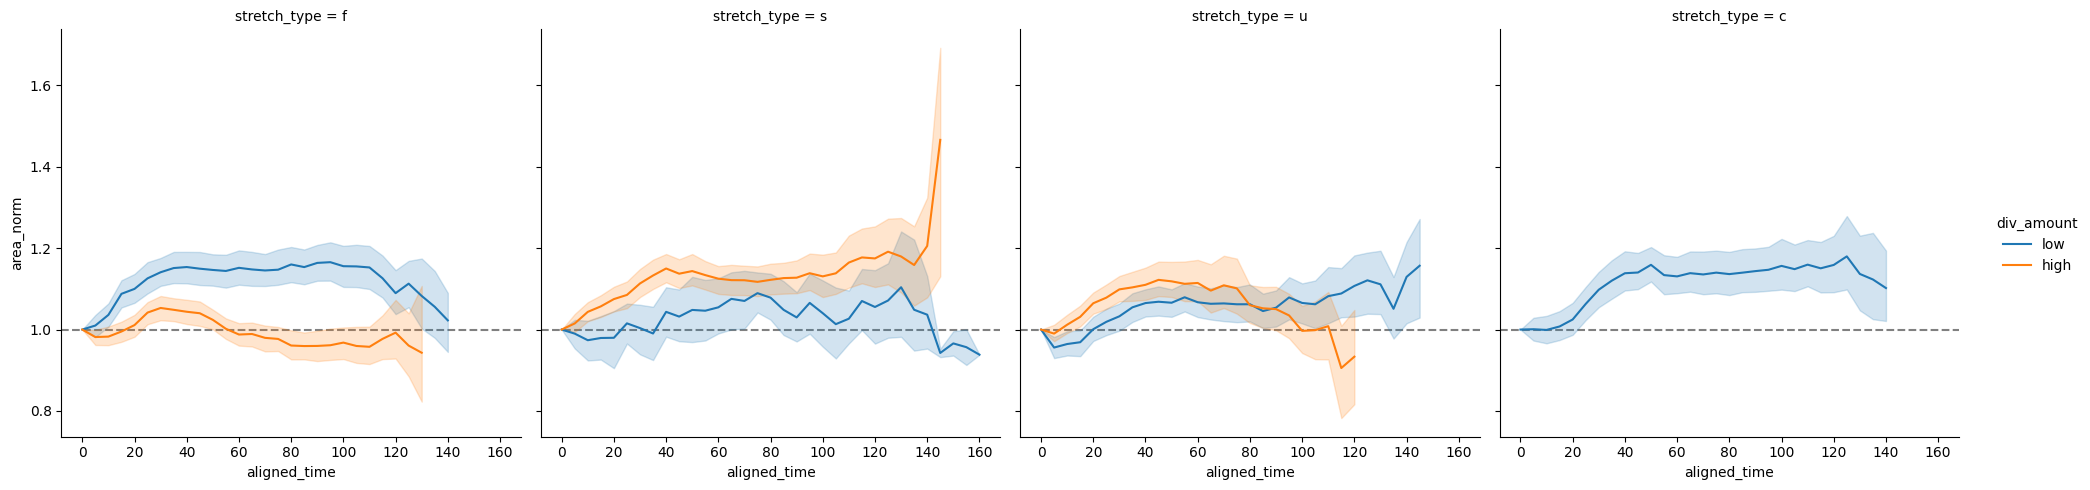

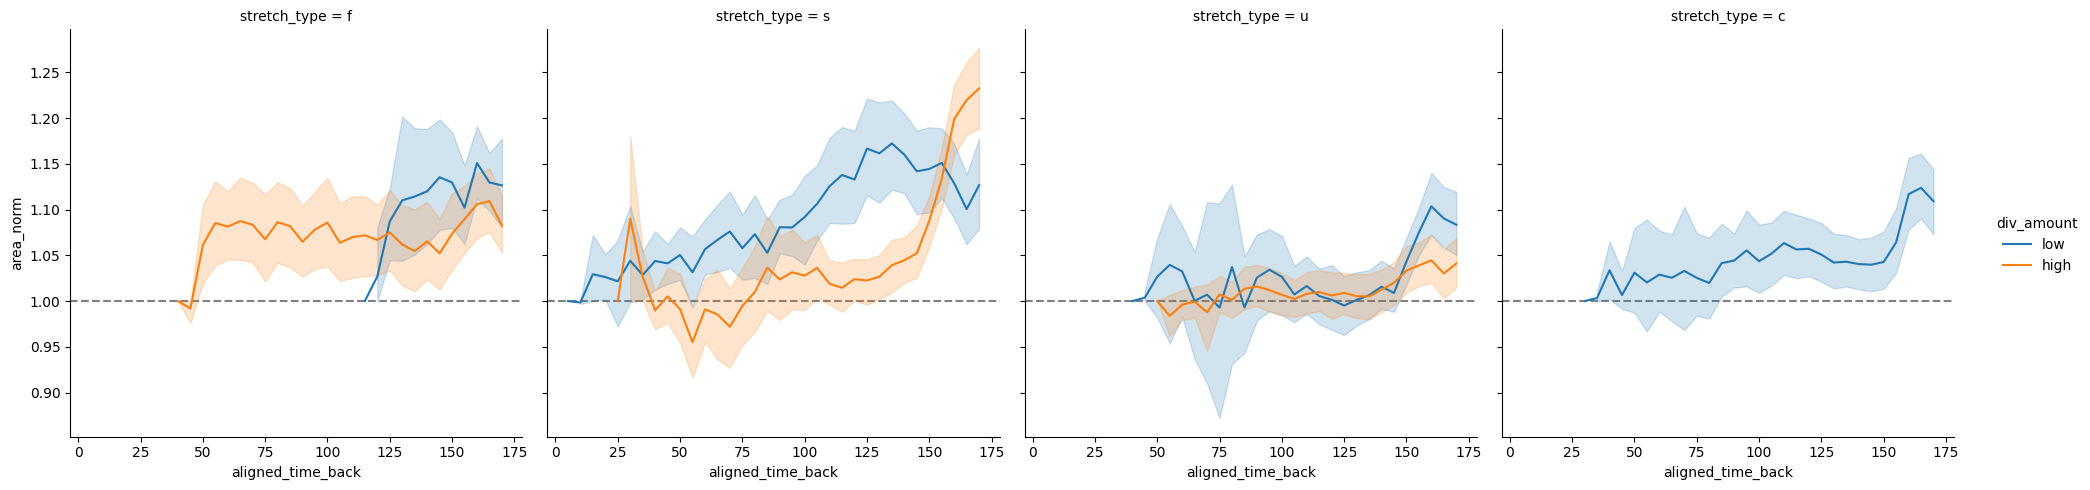

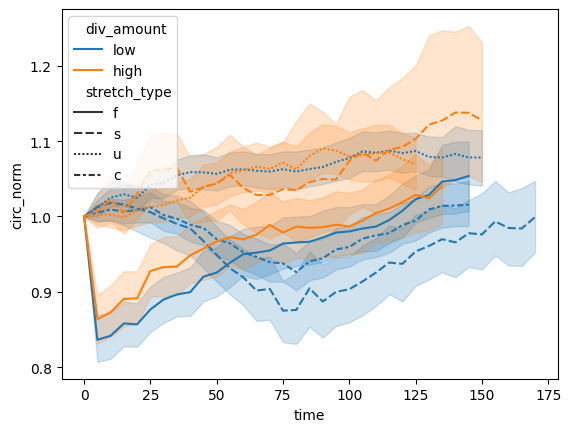

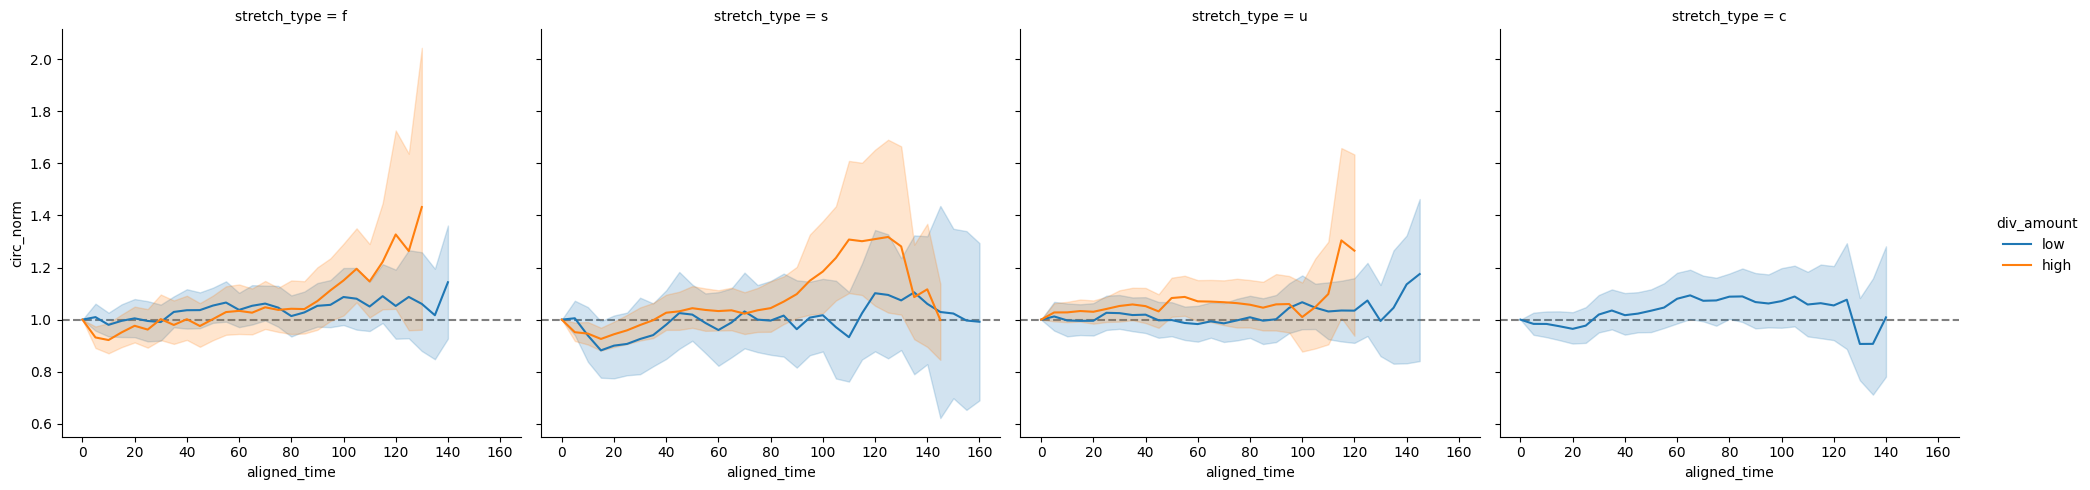

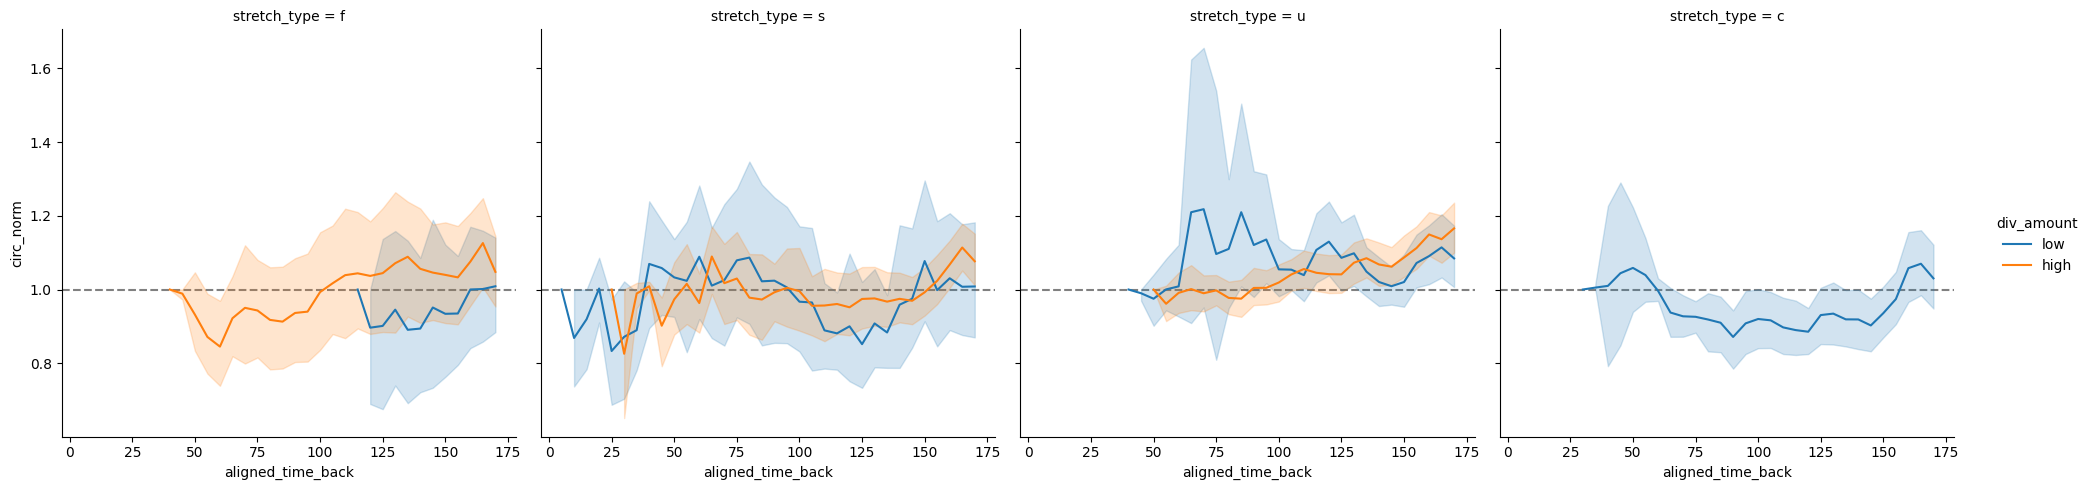

In [37]:
sns.lineplot(cell_data, x='time', y='area_norm', hue='div_amount', style='stretch_type')
plt.show()

g=sns.relplot(cell_data[cell_data.state=='daughter cell'], x='aligned_time', y='area_norm', hue='div_amount', col='stretch_type', kind='line')
g.map(plt.axhline, y=1,zorder=0, linestyle='--', color='grey')

plt.show()

g=sns.relplot(cell_data[cell_data.state=='will divide'], x='aligned_time_back', y='area_norm', hue='div_amount', col='stretch_type', kind='line')
g.map(plt.axhline, y=1,zorder=0, linestyle='--', color='grey')

plt.show()



sns.lineplot(cell_data, x='time', y='circ_J', hue='div_amount', style='stretch_type')
plt.show()

g=sns.relplot(cell_data[cell_data.state=='daughter cell'], x='aligned_time', y='circ_J', hue='div_amount', col='stretch_type', kind='line')
g.map(plt.axhline, y=1,zorder=0, linestyle='--', color='grey')

plt.show()

g=sns.relplot(cell_data[cell_data.state=='will divide'], x='aligned_time_back', y='circ_J', hue='div_amount', col='stretch_type', kind='line')
g.map(plt.axhline, y=1,zorder=0, linestyle='--', color='grey')

plt.show()

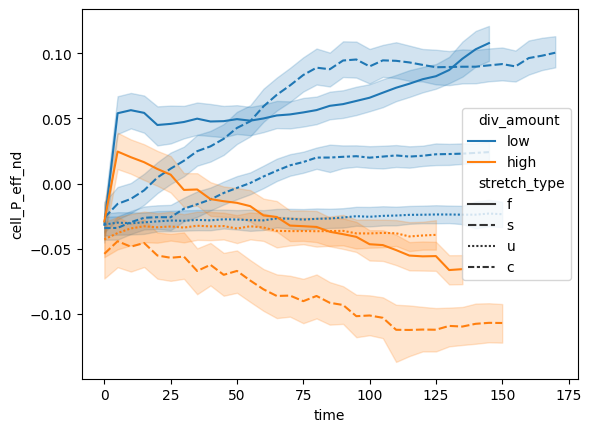

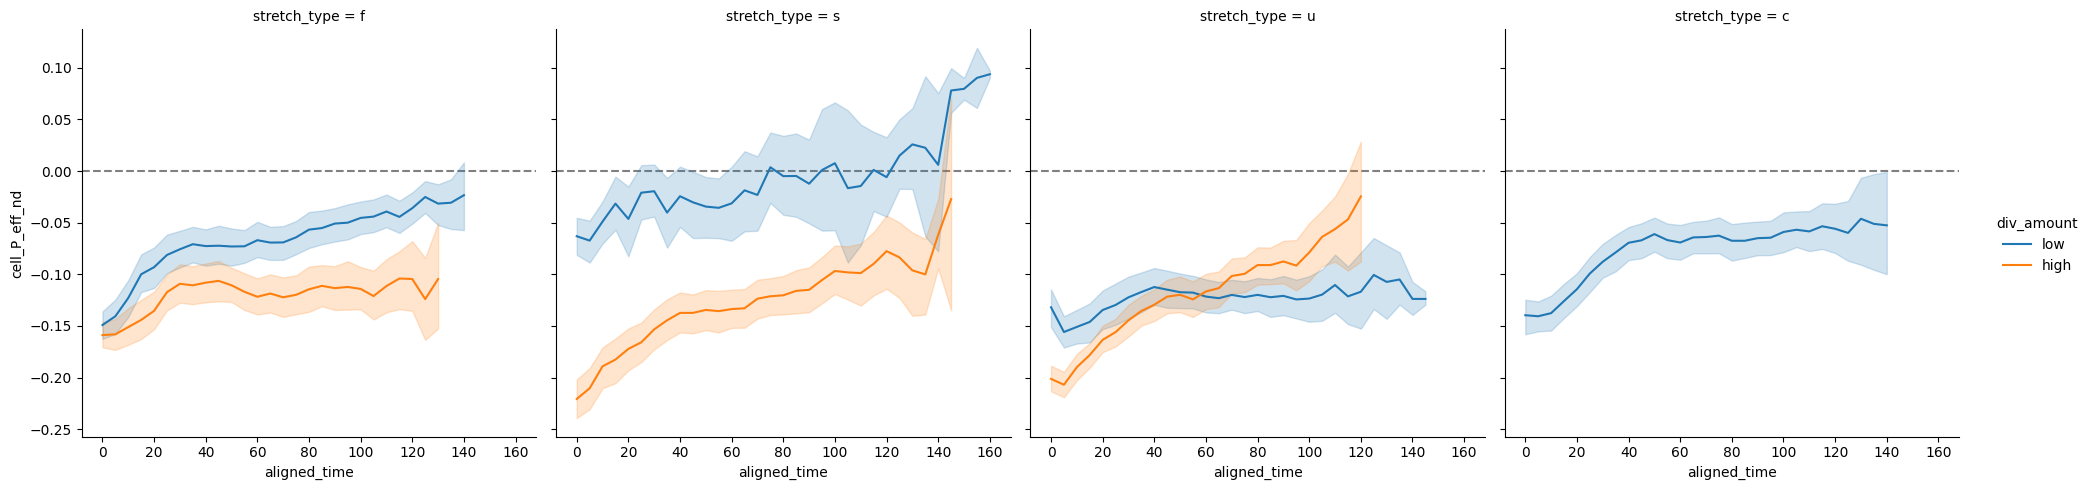

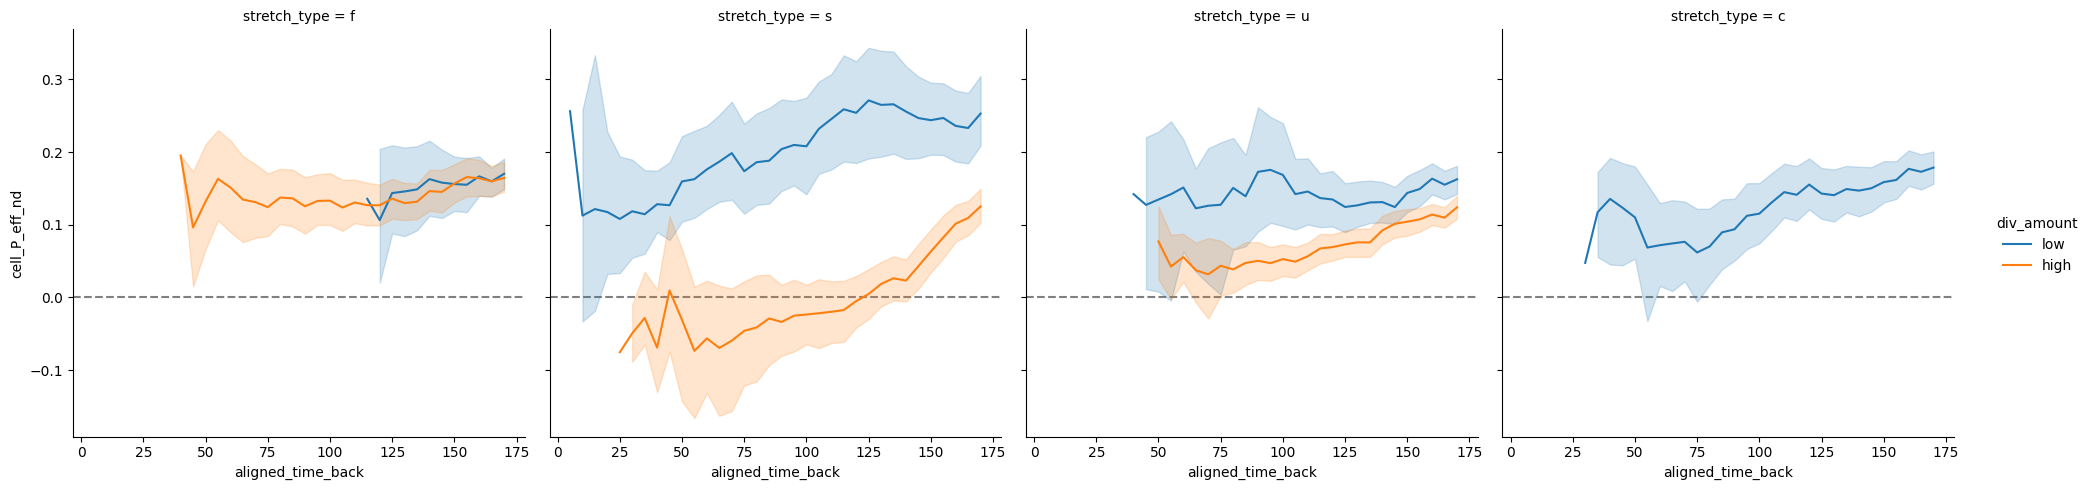

In [39]:


sns.lineplot(cell_data, x='time', y='cell_P_eff_nd', hue='div_amount', style='stretch_type')
plt.show()

g=sns.relplot(cell_data[cell_data.state=='daughter cell'], x='aligned_time', y='cell_P_eff_nd', hue='div_amount', col='stretch_type', kind='line')
g.map(plt.axhline, y=0,zorder=0, linestyle='--', color='grey')

plt.show()

g=sns.relplot(cell_data[cell_data.state=='will divide'], x='aligned_time_back', y='cell_P_eff_nd', hue='div_amount', col='stretch_type', kind='line')
g.map(plt.axhline, y=0,zorder=0, linestyle='--', color='grey')

plt.show()

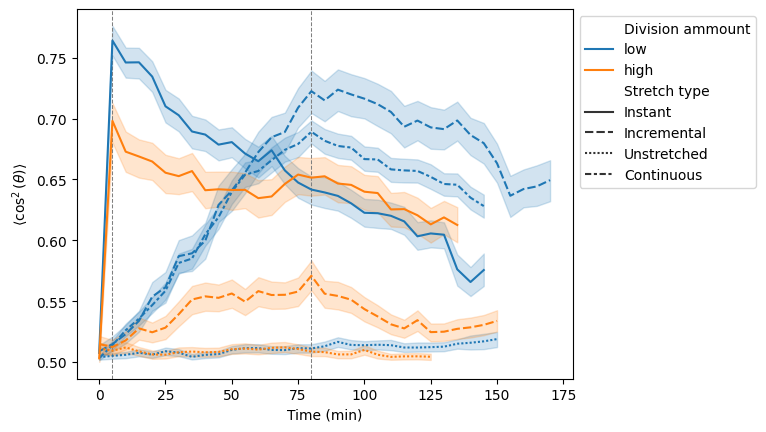

In [48]:
fig, ax=plt.subplots()
ax.axvline(5, linestyle='--', linewidth=0.75, color='grey')
ax.axvline(80, linestyle='--', linewidth=0.75, color='grey')
g=sns.lineplot(cell_data,ax=ax, x='time', y='order_all', hue='div_amount', style='stretch_type')
ax.set_ylabel(r"$\langle \cos^2(\theta)\rangle$")
ax.set_xlabel("Time (min)")

h, l=g.get_legend_handles_labels()
g.legend(h, ["Division ammount","low", "high", "Stretch type","Instant", "Incremental", "Unstretched", "Continuous"])
sns.move_legend(g, "upper left", bbox_to_anchor=(1,1), frameon=True)

plt.savefig(save_dir+'/division_amount_order.png', dpi=300, bbox_inches='tight')


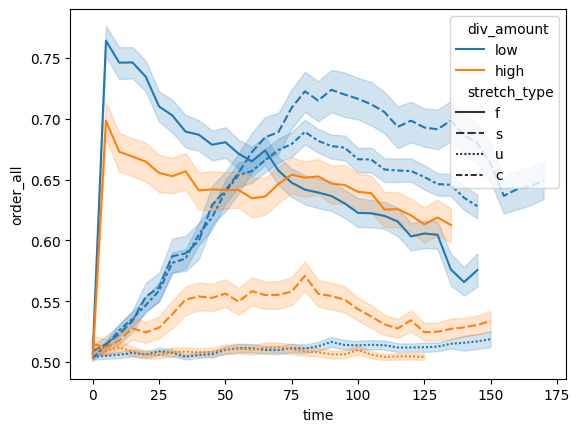

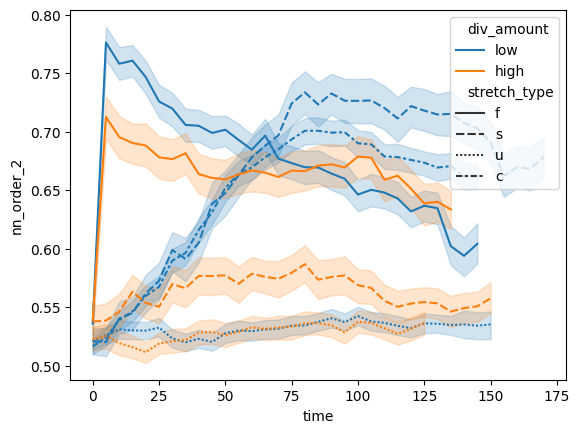

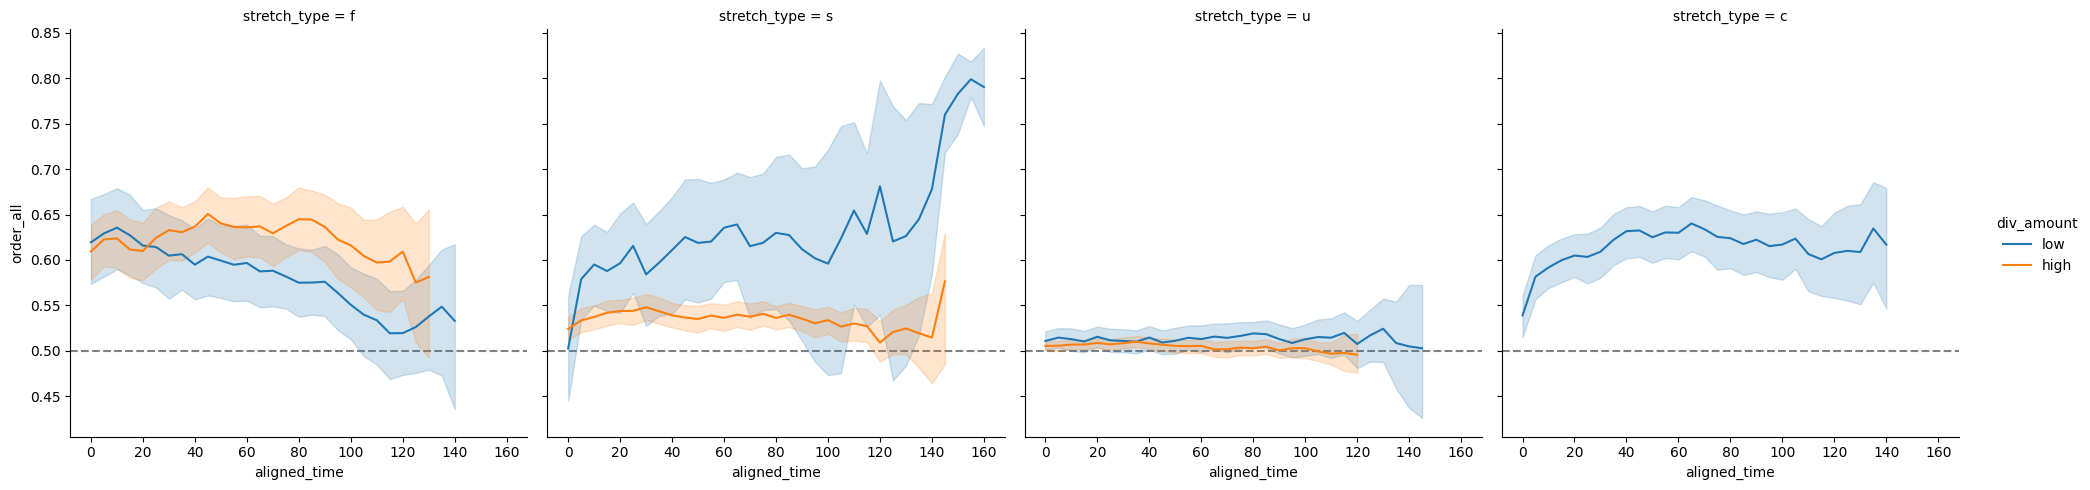

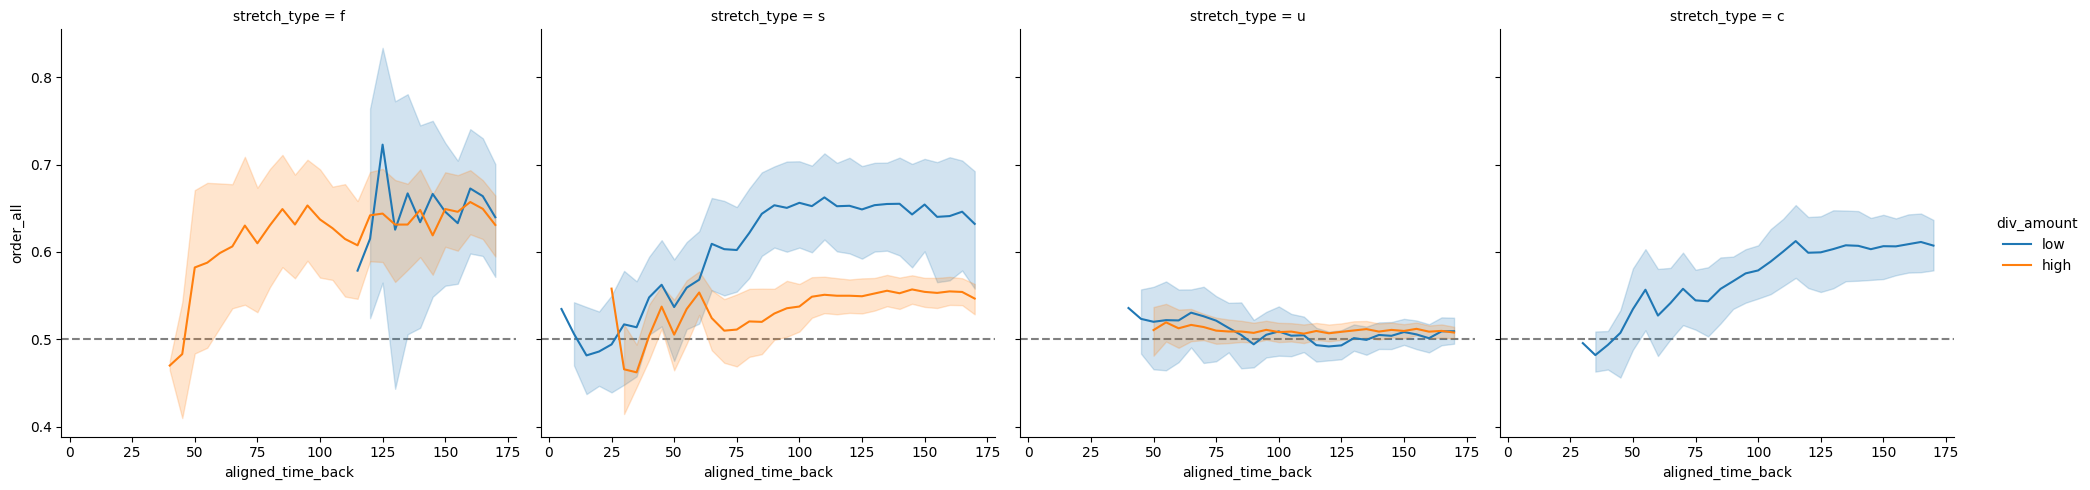

In [45]:


sns.lineplot(cell_data, x='time', y='order_all', hue='div_amount', style='stretch_type')
plt.show()

sns.lineplot(cell_data, x='time', y='ce', hue='div_amount', style='stretch_type')
plt.show()


g=sns.relplot(cell_data[cell_data.state=='daughter cell'], x='aligned_time', y='order_all', hue='div_amount', col='stretch_type', kind='line')
g.map(plt.axhline, y=0.5,zorder=0, linestyle='--', color='grey')

plt.show()

g=sns.relplot(cell_data[cell_data.state=='will divide'], x='aligned_time_back', y='order_all', hue='div_amount', col='stretch_type', kind='line')
g.map(plt.axhline, y=0.5,zorder=0, linestyle='--', color='grey')

plt.show()

In [156]:
will_div=cell_data[cell_data.state=='will divide']

In [157]:
will_div['initial_area']=will_div.groupby(['experiment', 'cell_id_new']).cell_area_microns.transform('first')
will_div['final_area']=will_div.groupby(['experiment', 'cell_id_new']).cell_area_microns.transform('last')
will_div['final_area_norm']=will_div.groupby(['experiment', 'cell_id_new']).area_norm.transform('last')

C:\Users\v35431nc\AppData\Local\Temp\ipykernel_33796\3362703929.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  will_div['initial_area']=will_div.groupby(['experiment', 'cell_id_new']).cell_area_microns.transform('first')
C:\Users\v35431nc\AppData\Local\Temp\ipykernel_33796\3362703929.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  will_div['final_area']=will_div.groupby(['experiment', 'cell_id_new']).cell_area_microns.transform('last')
C:\Users\v35431nc\AppData\Local\Temp\ipykernel_33796\3362703929

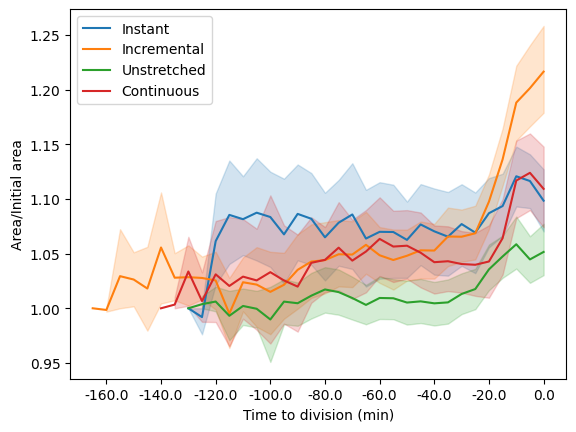

In [63]:
fig, ax=plt.subplots()
g=sns.lineplot(cell_data[cell_data.state=='will divide'], ax=ax,x='aligned_time_back', y='area_norm', hue='stretch_type')

h,l=g.get_legend_handles_labels()
g.legend(h, ["Instant", "Incremental", "Unstretched", "Continuous"])
ax.set_ylabel("Area/Initial area")
ax.set_xlabel("Time to division (min)")

ax.set_xticks(np.linspace(10, 170, 9), labels=np.linspace(-160, 0, 9))

plt.savefig(save_dir+'/area_will_div_aligned.png', dpi=300, bbox_inches='tight')


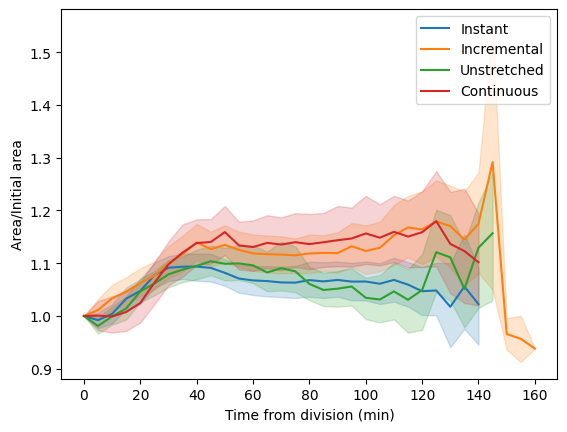

In [353]:
fig, ax=plt.subplots()
g=sns.lineplot(cell_data[cell_data.state=='daughter cell'], ax=ax,x='aligned_time', y='area_norm', hue='stretch_type')

h,l=g.get_legend_handles_labels()
g.legend(h, ["Instant", "Incremental", "Unstretched", "Continuous"])
ax.set_ylabel("Area/Initial area")
ax.set_xlabel("Time from division (min)")

#ax.set_xticks(np.linspace(10, 170, 9), labels=np.linspace(-160, 0, 9))

plt.savefig(save_dir+'/area_daughter_aligned.png', dpi=300, bbox_inches='tight')


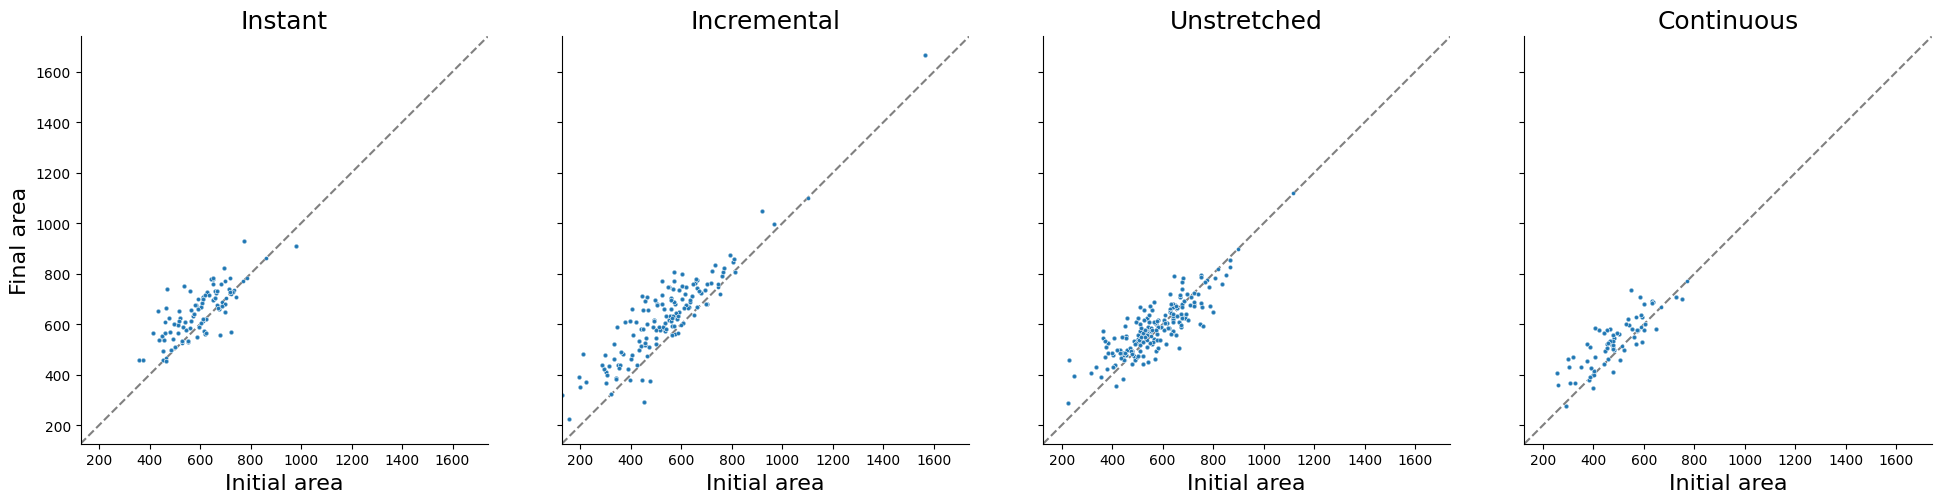

In [85]:
g=sns.relplot(will_div, x='initial_area', y='final_area', kind='scatter', col='stretch_type', s=8,aspect=1)
g.map(plt.axline, xy1=(200,200), slope=1, zorder=0, linestyle='--', color='grey')
g.axes[0,0].set_ylabel('Final area', fontsize=16)
g.axes[0,0].set_xlabel('Initial area', fontsize=16)
g.axes[0,1].set_xlabel('Initial area', fontsize=16)
g.axes[0,2].set_xlabel('Initial area', fontsize=16)
g.axes[0,3].set_xlabel('Initial area', fontsize=16)

g.axes[0,0].set_title('Instant', fontsize=18)
g.axes[0,1].set_title('Incremental', fontsize=18)
g.axes[0,2].set_title('Unstretched', fontsize=18)
g.axes[0,3].set_title('Continuous', fontsize=18)

for ax in g.fig.axes:
    ax.set_xlim(ax.get_ylim())
    ax.set_aspect('equal')


plt.savefig(save_dir+'/will_div_final_initial.png', dpi=300, bbox_inches='tight')



In [51]:
exp_time_data

experiment     total_area  cell_count stretch_type  cell_density  \
0    con_20240412_2_IP  162341.821624         456            c      0.002809   
1    con_20240412_2_IP  162360.525222         459            c      0.002827   
2    con_20240412_2_IP  163430.283338         459            c      0.002809   
3    con_20240412_2_IP  163003.023028         460            c      0.002822   
4    con_20240412_2_IP  163119.189904         463            c      0.002838   
..                 ...            ...         ...          ...           ...   
326  uns_20240117_2_IP  148309.593563         405            u      0.002731   
327  uns_20240117_2_IP  149110.487462         406            u      0.002723   
328  uns_20240117_2_IP  149854.539959         406            u      0.002709   
329  uns_20240117_2_IP  150457.292619         406            u      0.002698   
330  uns_20240117_2_IP  150883.968442         406            u      0.002691   

     mean_area_per_cell div_amount  
0            356.012767        low  
1            353.726634        low  
2            356.057262        low  
3            354.354398        low  
4            352.309265        low  
..                  ...        ...  
326          366.196527        low  
327          367.267210        low  
328          369.099852        low  
329          370.584465        low  
330          371.635390        low  

[331 rows x 7 columns]

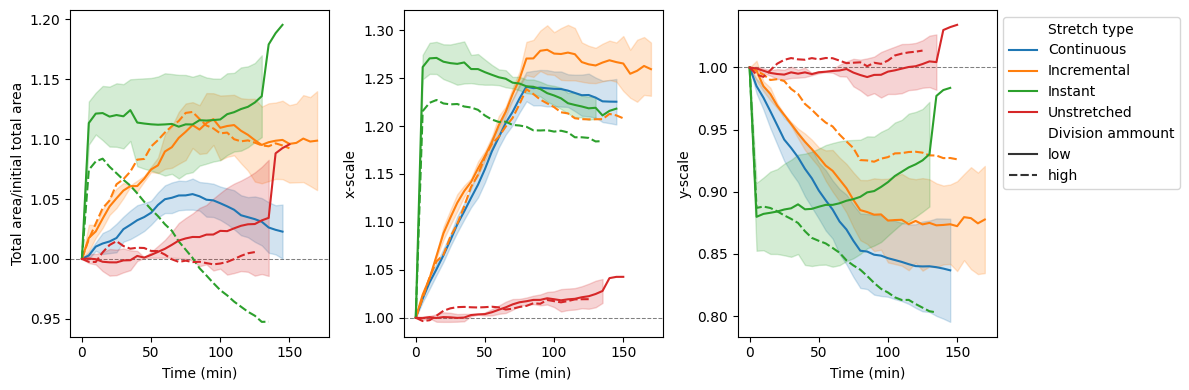

In [178]:
fig,ax=plt.subplots(1,3, figsize=(12,4), sharex=True)
sns.lineplot(exp_time_data,ax=ax[0], x='time',y='total_area_norm', style='div_amount',hue='stretch_type', legend=False )

sns.lineplot(exp_time_data, ax=ax[1],x='time',y='x_scale',style='div_amount',hue='stretch_type', legend=False )


g=sns.lineplot(exp_time_data, ax=ax[2],x='time',y='y_scale', style='div_amount',hue='stretch_type')
h, l=g.get_legend_handles_labels()
g.legend(h, [ "Stretch type","Continuous", "Incremental", "Instant", "Unstretched","Division ammount","low", "high",])
sns.move_legend(g, "upper left", bbox_to_anchor=(1,1), frameon=True)

ax[0].axhline(1,zorder=0, linestyle='--', color='grey', linewidth=0.75)
ax[1].axhline(1,zorder=0, linestyle='--', color='grey', linewidth=0.75)
ax[2].axhline(1,zorder=0, linestyle='--', color='grey', linewidth=0.75)

ax[0].set_xlabel('Time (min)')
ax[1].set_xlabel('Time (min)')
ax[2].set_xlabel('Time (min)')

ax[0].set_ylabel('Total area/initial total area')
ax[1].set_ylabel('x-scale')
ax[2].set_ylabel('y-scale')
plt.tight_layout()

plt.savefig(save_dir+'/tissue_deformation.png', dpi=300, bbox_inches='tight')


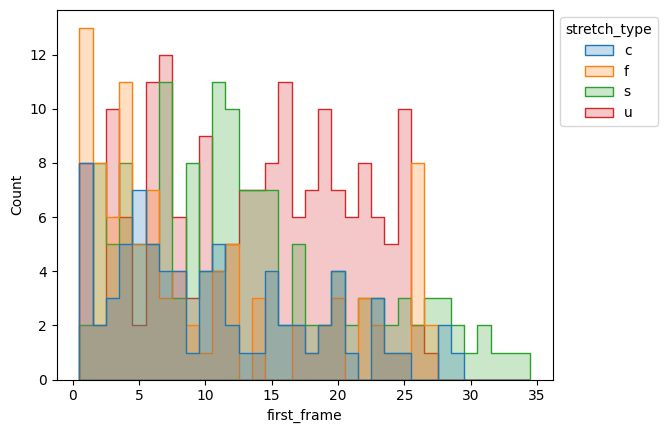

In [321]:
g=sns.histplot(d_dists, x='first_frame', hue='stretch_type', discrete=True, element='step')

sns.move_legend(g, "upper left", bbox_to_anchor=(1,1), frameon=True)



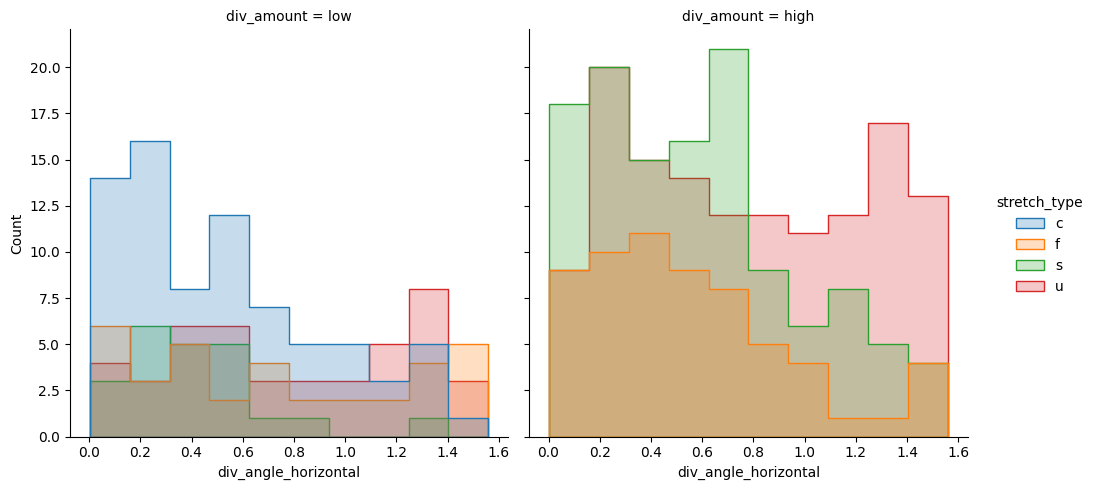

In [89]:
sns.displot(d_dists, x='div_angle_horizontal', hue='stretch_type', col='div_amount', element='step')

In [137]:
np.linspace(0,32, 5)

array([ 0.,  8., 16., 24., 32.])

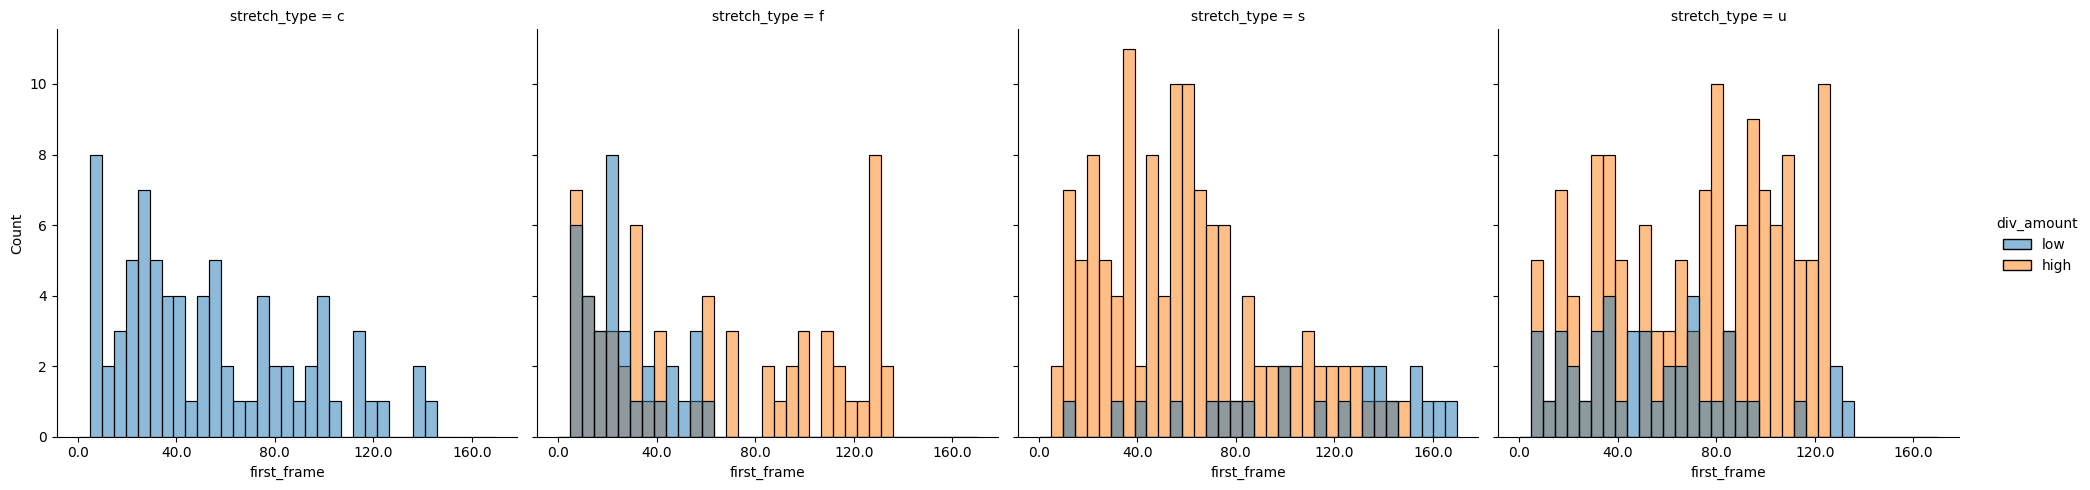

In [138]:
g=sns.displot(d_dists, x='first_frame', col='stretch_type', hue='div_amount', binrange=(0,34), bins=35)
g.axes[0, 0].set_xticks(np.linspace(0,32, 5),np.linspace(0,32, 5)*5)

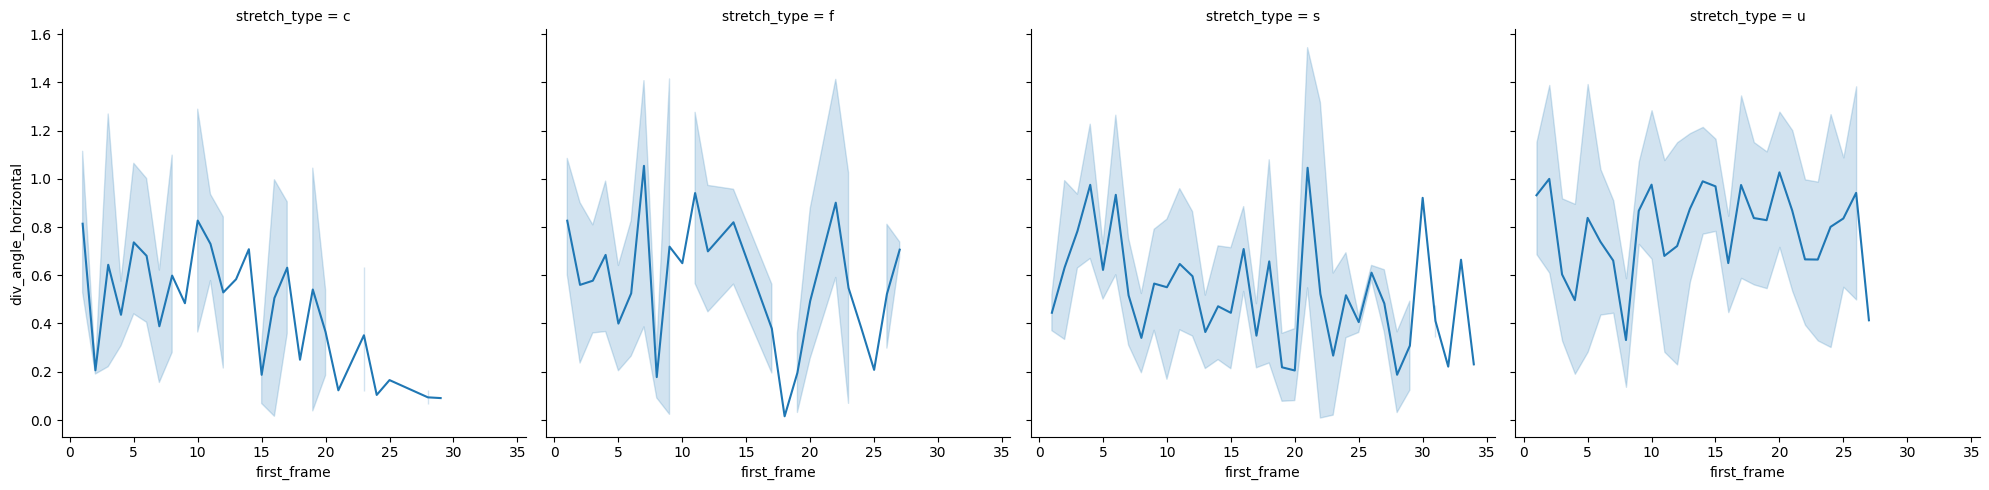

In [96]:
sns.relplot(d_dists, x='first_frame',y='div_angle_horizontal', col='stretch_type', kind='line')

In [164]:
div_pos_time=will_div.groupby(['experiment', 'cell_id_new']).last()[['cc_x', 'cc_y', 'time']].reset_index()

In [168]:
sns.color_palette('jet', 33)

ValueError: No.

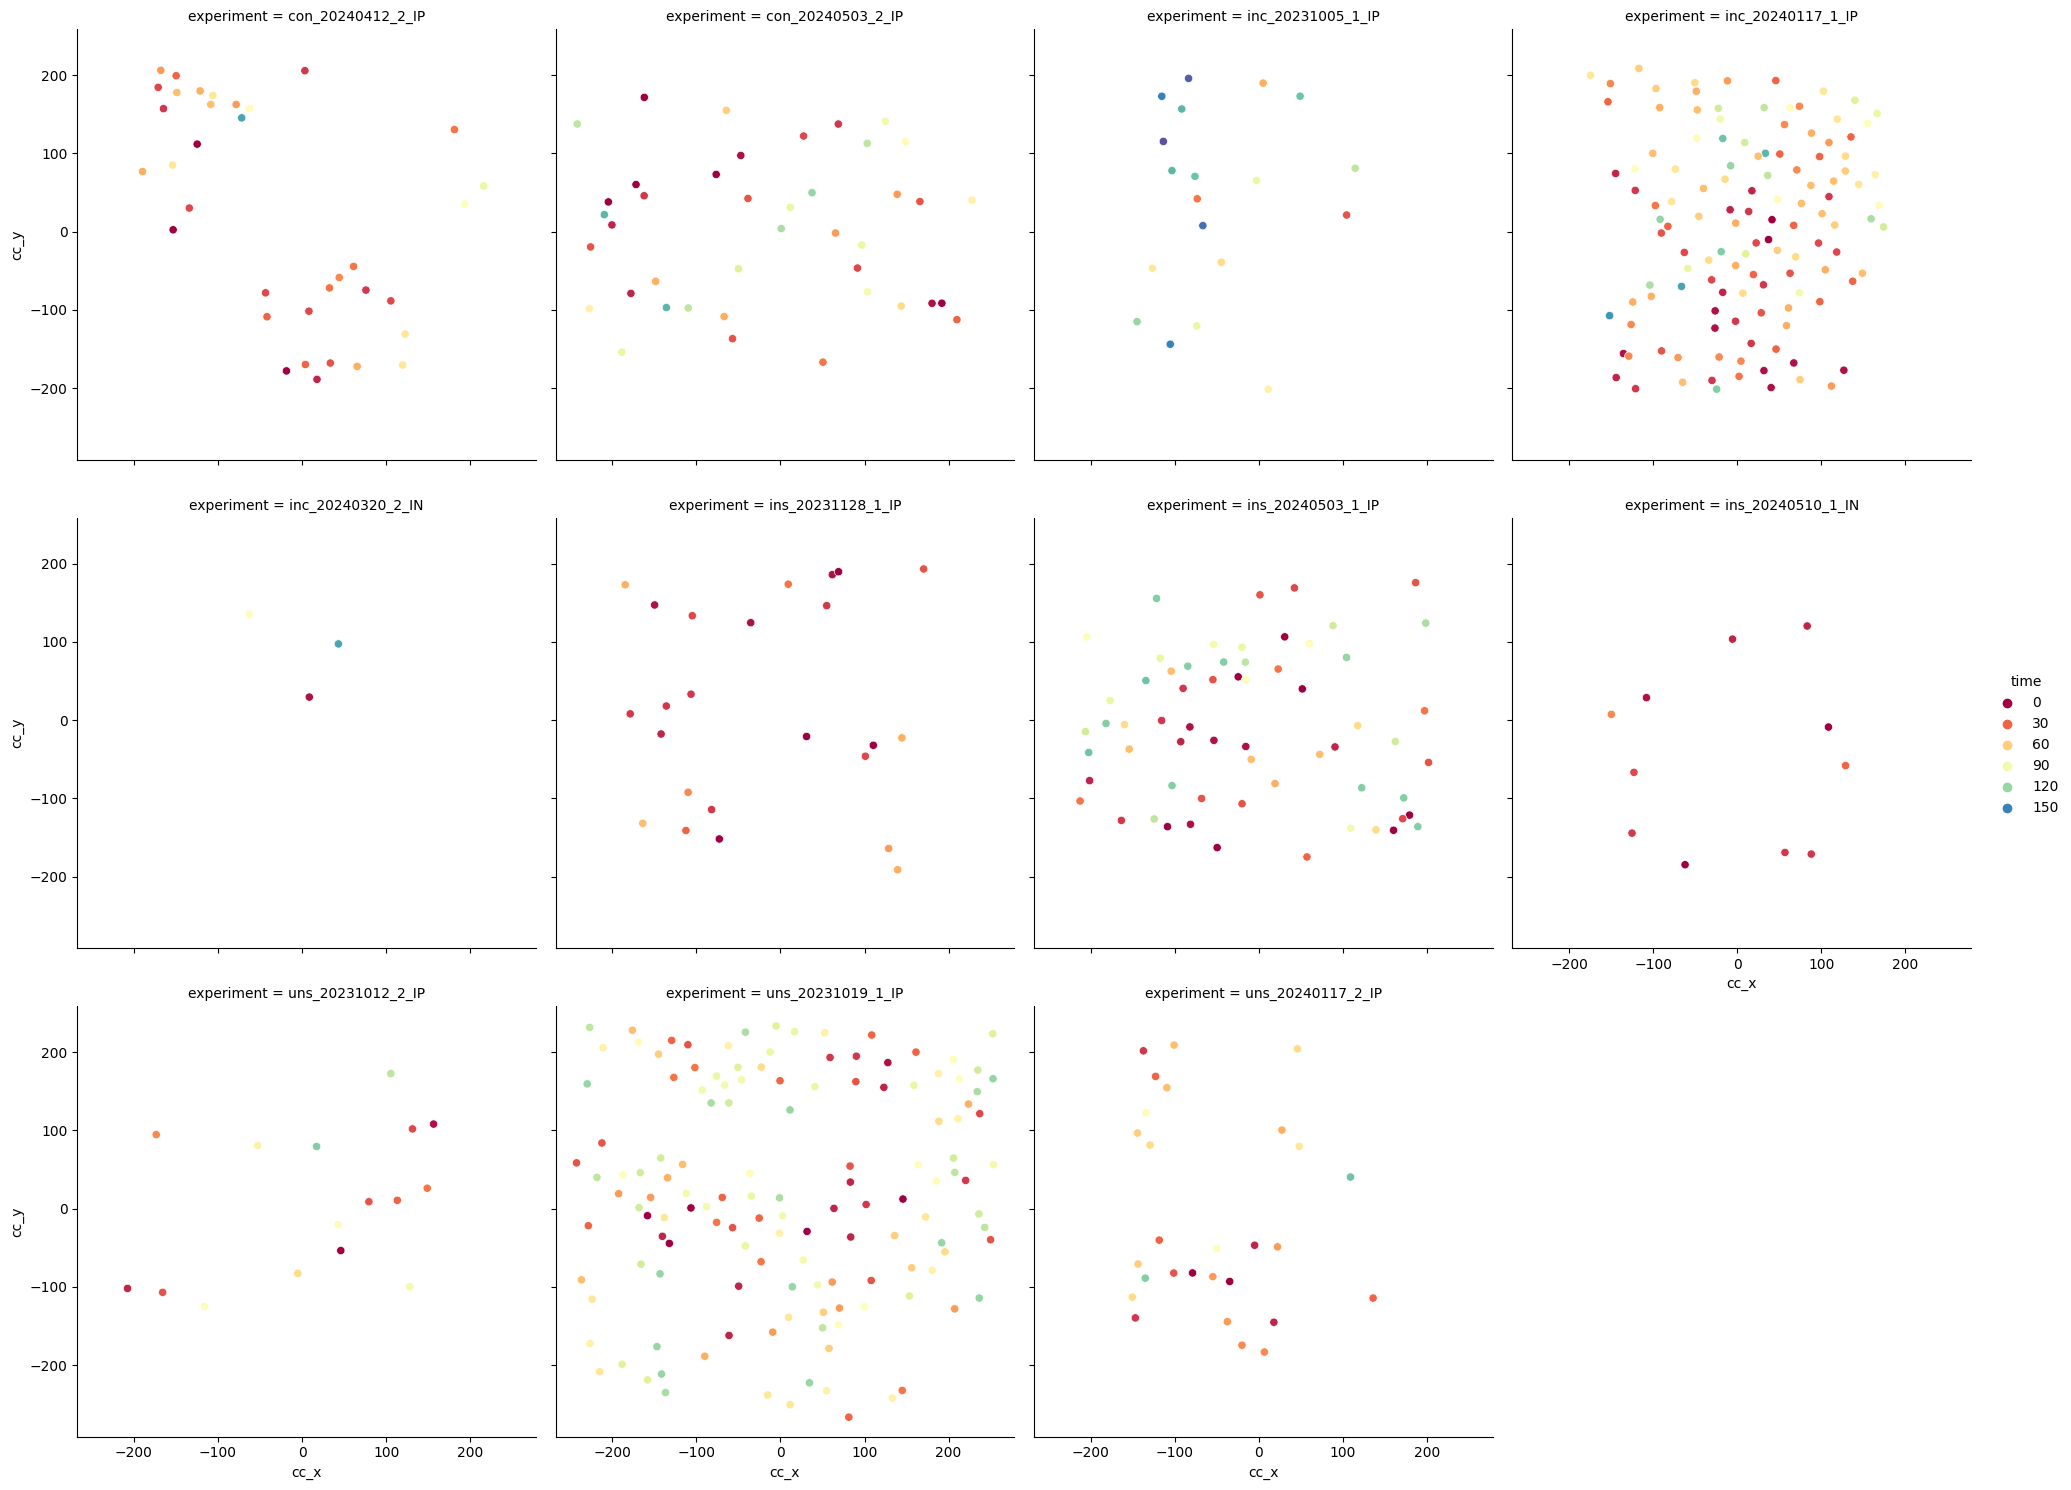

In [174]:
sns.relplot(div_pos_time, x='cc_x', y='cc_y', hue='time' ,col='experiment', col_wrap=4, palette='Spectral')

In [209]:
div_dat=d_dists.merge(will_div.groupby(['experiment', 'cell_id_new']).last()[['major_shape_axis_alignment_rads', 'angle_horizontal']].reset_index(), left_on=['experiment', 'parent_id'],right_on=['experiment', 'cell_id_new'])
div_dat=div_dat.rename(columns={'major_shape_axis_alignment_rads':'shape_angle'})
div_dat['shape_div_alignment']=np.cos(abs(div_dat.shape_angle-div_dat.div_angle))**2
div_dat['shape_stretch_alignment']=np.cos(div_dat.shape_angle)**2
div_dat['div_stretch_alignment']=np.cos(div_dat.div_angle)**2

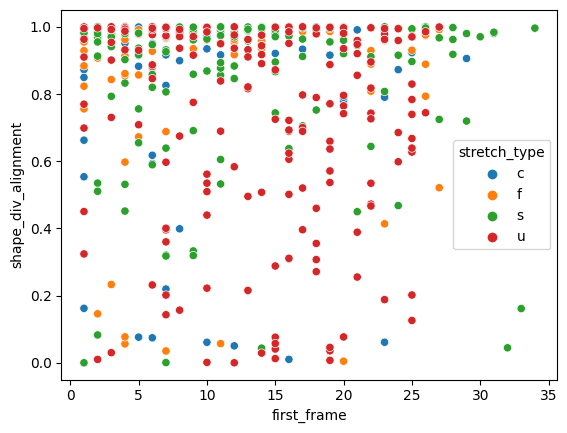

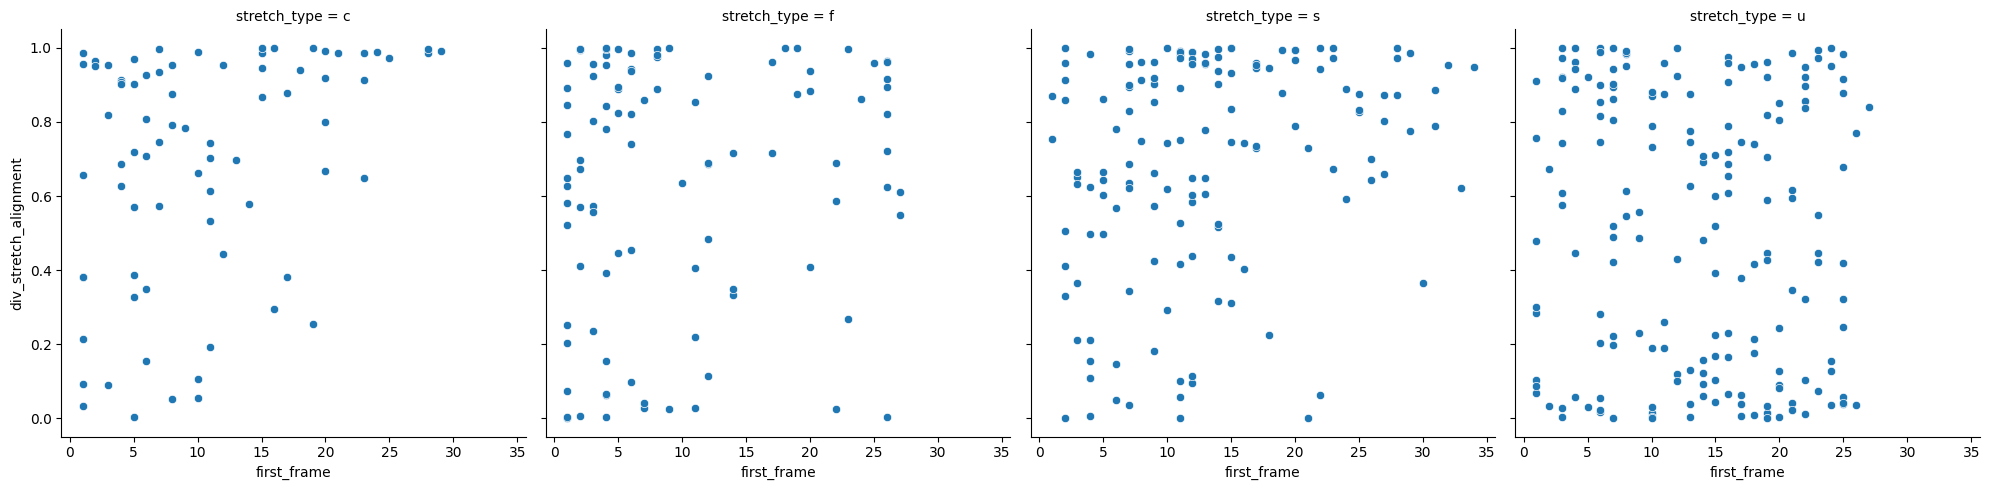

In [223]:
sns.scatterplot(div_dat, x='first_frame',y='shape_div_alignment', hue='stretch_type')
plt.show()

sns.relplot(div_dat, x='first_frame',y='div_stretch_alignment', col='stretch_type')

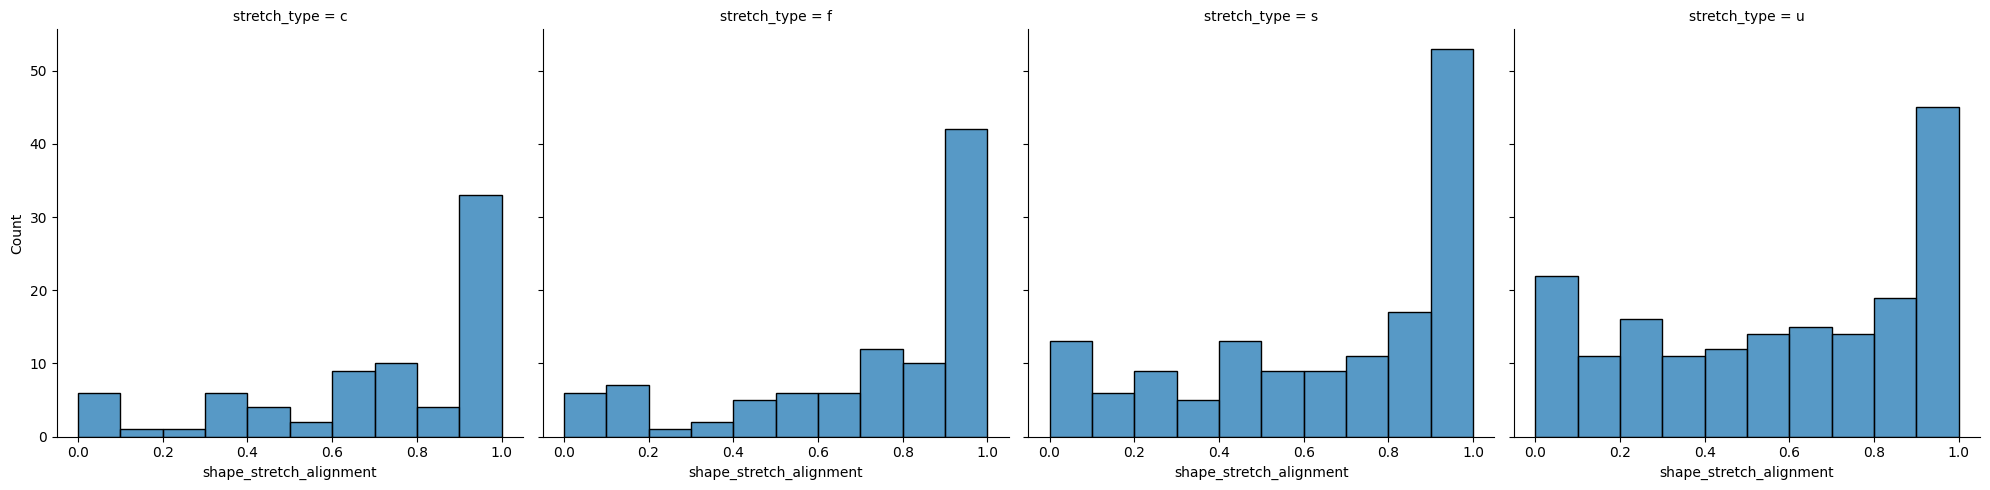

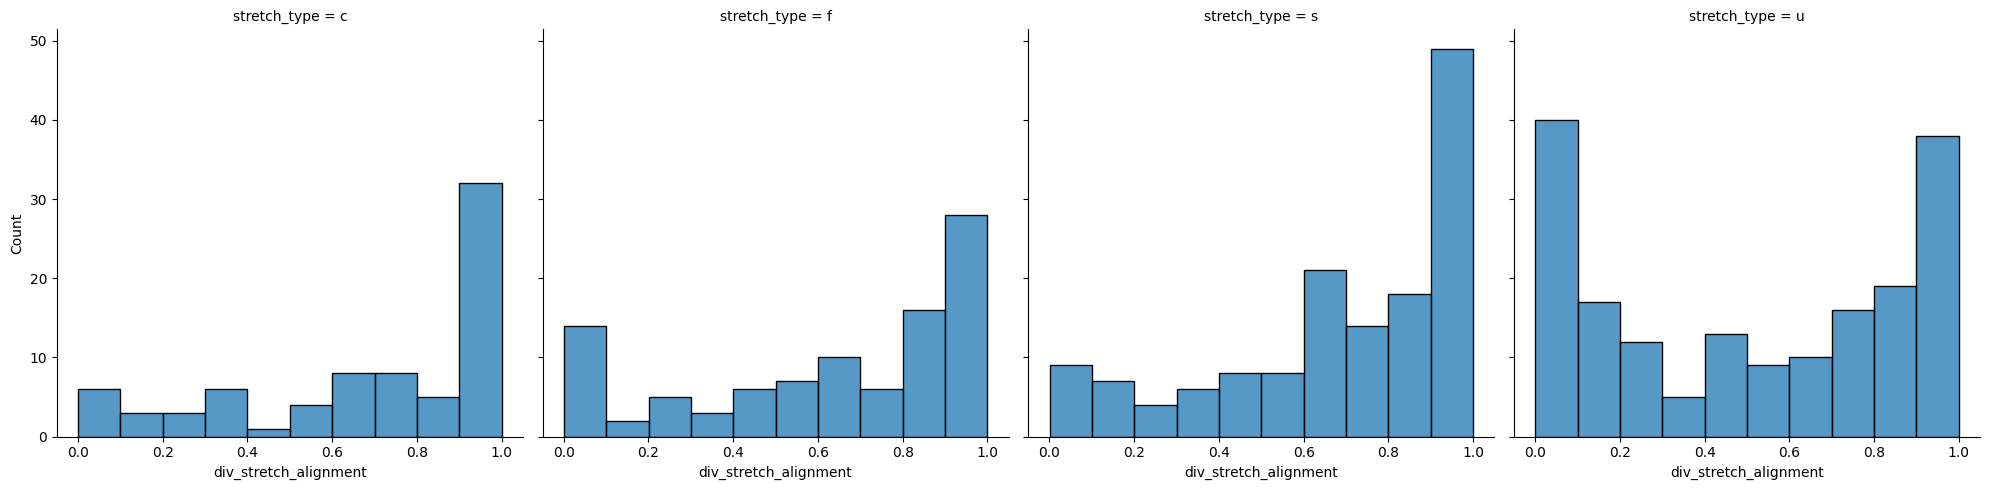

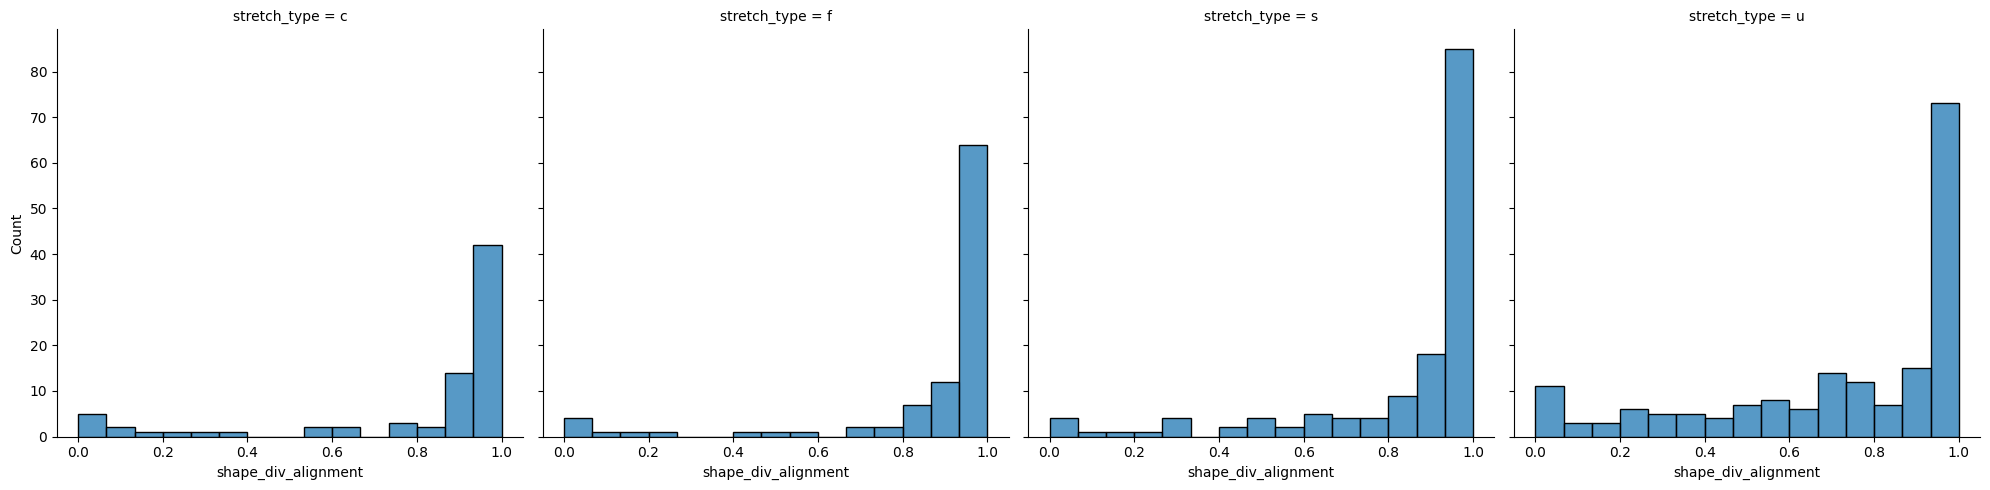

In [215]:
sns.displot(div_dat, x='shape_stretch_alignment', col='stretch_type')
sns.displot(div_dat, x='div_stretch_alignment', col='stretch_type')
sns.displot(div_dat, x='shape_div_alignment', col='stretch_type')

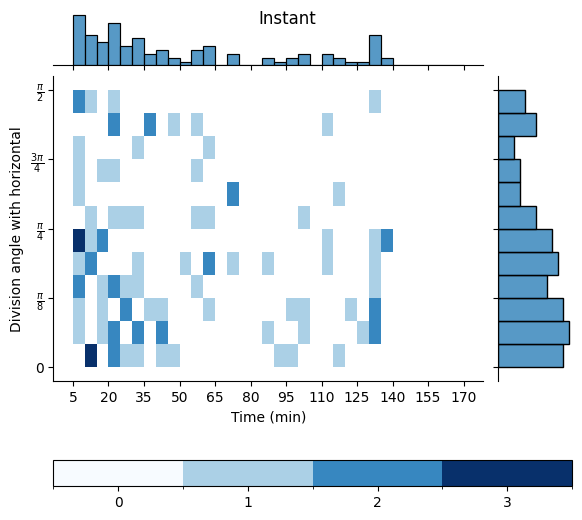

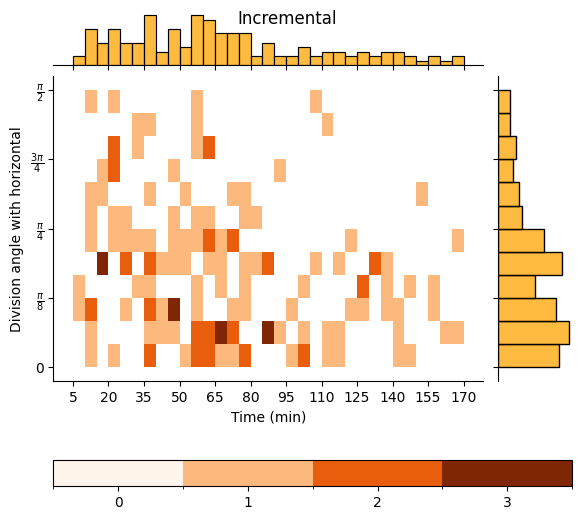

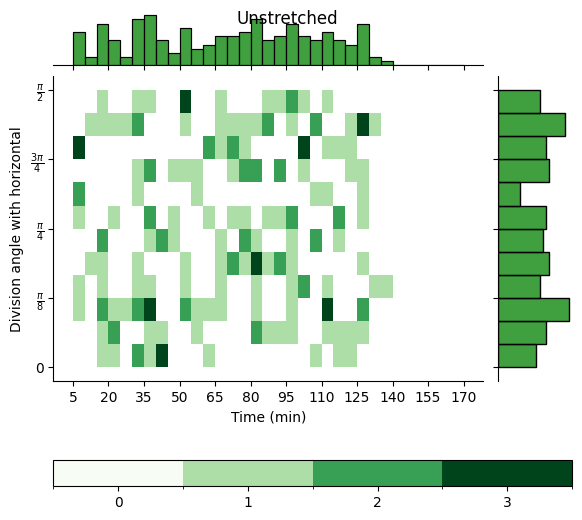

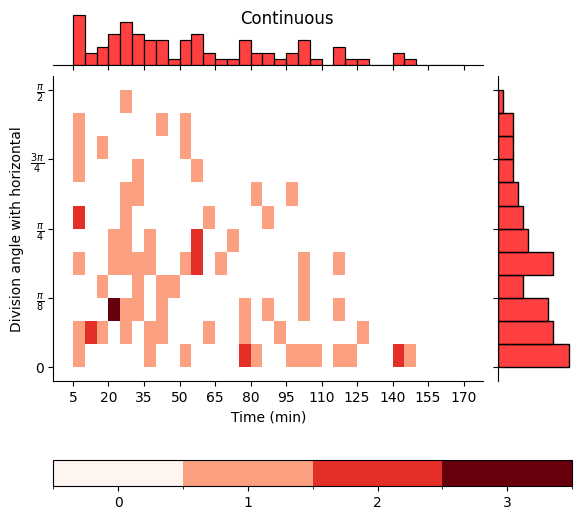

In [358]:

g=sns.jointplot(div_dat[div_dat.stretch_type=='f'],x='first_frame', y='div_angle_horizontal', kind='hist', bins=(33, 12), binrange=((1,34),(0, np.pi/2)),cmap='Blues')

g.ax_joint.set_xticks(np.linspace(1,34,12), (np.linspace(1,34,12)*5).astype(int))
g.ax_joint.set_yticks(np.linspace(0, np.pi/2, 5),['0',r'$\frac{\pi}{8}$', r'$\frac{\pi}{4}$',r'$\frac{3\pi}{4}$',r'$\frac{\pi}{2}$'])

g.ax_joint.set_xlabel("Time (min)")
g.ax_joint.set_ylabel("Division angle with horizontal")
plt.suptitle("Instant")
cmap=sns.color_palette("Blues", as_cmap=True)
bounds = [-0.5, 0.5, 1.5,2.5, 3.5]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
g.fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=[g.ax_joint, g.ax_marg_y, g.ax_marg_x], use_gridspec=True, orientation='horizontal', ticks=[0, 1, 2, 3])
plt.savefig(save_dir+'/div_angle_time_instant.png', dpi=300, bbox_inches='tight')

plt.show()

g=sns.jointplot(div_dat[div_dat.stretch_type=='s'],x='first_frame', y='div_angle_horizontal', kind='hist', bins=(33, 12), binrange=((1,34),(0, np.pi/2)),cmap='Oranges', color='orange')


g.ax_joint.set_xticks(np.linspace(1,34,12), (np.linspace(1,34,12)*5).astype(int))
g.ax_joint.set_yticks(np.linspace(0, np.pi/2, 5),['0',r'$\frac{\pi}{8}$', r'$\frac{\pi}{4}$',r'$\frac{3\pi}{4}$',r'$\frac{\pi}{2}$'])

g.ax_joint.set_xlabel("Time (min)")
g.ax_joint.set_ylabel("Division angle with horizontal")
plt.suptitle("Incremental")

cmap=sns.color_palette("Oranges", as_cmap=True)
bounds = [-0.5, 0.5, 1.5,2.5, 3.5]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
g.fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=[g.ax_joint, g.ax_marg_y, g.ax_marg_x], use_gridspec=True, orientation='horizontal', ticks=[0, 1, 2, 3])
#plt.savefig(save_dir+'/div_angle_time_incremental.png', dpi=300, bbox_inches='tight')
plt.show()

g=sns.jointplot(div_dat[div_dat.stretch_type=='u'],x='first_frame', y='div_angle_horizontal', kind='hist', bins=(33, 12), binrange=((1,34),(0, np.pi/2)),cmap='Greens', color='green')


g.ax_joint.set_xticks(np.linspace(1,34,12), (np.linspace(1,34,12)*5).astype(int))
g.ax_joint.set_yticks(np.linspace(0, np.pi/2, 5),['0',r'$\frac{\pi}{8}$', r'$\frac{\pi}{4}$',r'$\frac{3\pi}{4}$',r'$\frac{\pi}{2}$'])

g.ax_joint.set_xlabel("Time (min)")
g.ax_joint.set_ylabel("Division angle with horizontal")
plt.suptitle("Unstretched")

cmap=sns.color_palette("Greens", as_cmap=True)
bounds = [-0.5, 0.5, 1.5,2.5, 3.5]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
g.fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=[g.ax_joint, g.ax_marg_y, g.ax_marg_x], use_gridspec=True, orientation='horizontal', ticks=[0, 1, 2, 3])
#plt.savefig(save_dir+'/div_angle_time_unstretched.png', dpi=300, bbox_inches='tight')
plt.show()


g=sns.jointplot(div_dat[div_dat.stretch_type=='c'],x='first_frame', y='div_angle_horizontal', kind='hist', bins=(33, 12), binrange=((1,34),(0, np.pi/2)),cmap='Reds', color='red')


g.ax_joint.set_xticks(np.linspace(1,34,12), (np.linspace(1,34,12)*5).astype(int))
g.ax_joint.set_yticks(np.linspace(0, np.pi/2, 5),['0',r'$\frac{\pi}{8}$', r'$\frac{\pi}{4}$',r'$\frac{3\pi}{4}$',r'$\frac{\pi}{2}$'])

g.ax_joint.set_xlabel("Time (min)")
g.ax_joint.set_ylabel("Division angle with horizontal")
plt.suptitle("Continuous")
cmap=sns.color_palette("Reds", as_cmap=True)
bounds = [-0.5, 0.5, 1.5,2.5, 3.5]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
g.fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=[g.ax_joint, g.ax_marg_y, g.ax_marg_x], use_gridspec=True, orientation='horizontal', ticks=[0, 1, 2, 3])
#plt.savefig(save_dir+'/div_angle_time_continuous.png', dpi=300, bbox_inches='tight')
plt.show()

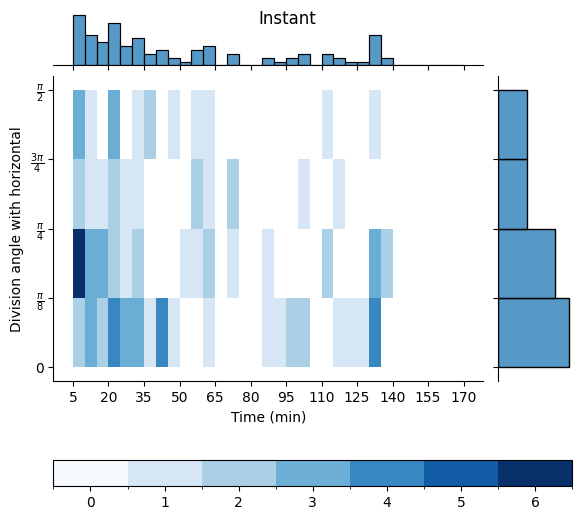

In [315]:

g=sns.jointplot(div_dat[div_dat.stretch_type=='f'],x='first_frame', y='div_angle_horizontal', kind='hist', bins=(33, 4),binrange=((1,34),(0, np.pi/2)),cmap='Blues')

g.ax_joint.set_xticks(np.linspace(1,34,12), (np.linspace(1,34,12)*5).astype(int))
g.ax_joint.set_yticks(np.linspace(0, np.pi/2, 5),['0',r'$\frac{\pi}{8}$', r'$\frac{\pi}{4}$',r'$\frac{3\pi}{4}$',r'$\frac{\pi}{2}$'])

g.ax_joint.set_xlabel("Time (min)")
g.ax_joint.set_ylabel("Division angle with horizontal")
plt.suptitle("Instant")
cmap=sns.color_palette("Blues", as_cmap=True)
bounds = [-0.5, 0.5, 1.5,2.5, 3.5, 4.5, 5.5, 6.5]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
g.fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=[g.ax_joint, g.ax_marg_y, g.ax_marg_x], use_gridspec=True, orientation='horizontal', ticks=[0, 1, 2, 3, 4, 5, 6])
#plt.savefig(save_dir+'/div_angle_time_instant.png', dpi=300, bbox_inches='tight')

plt.show()

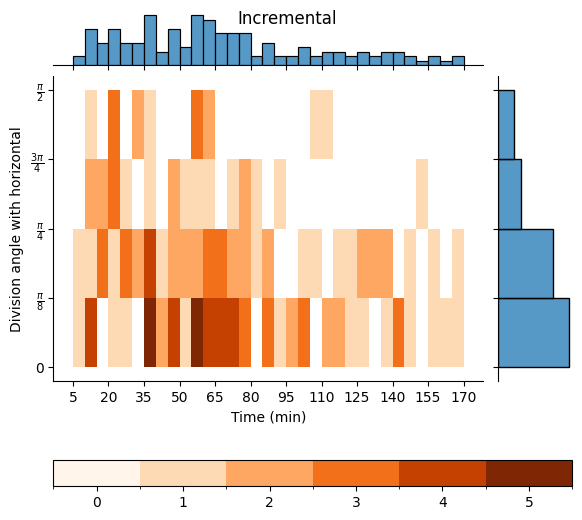

In [320]:

g=sns.jointplot(div_dat[div_dat.stretch_type=='s'],x='first_frame', y='div_angle_horizontal', kind='hist', bins=(33, 4),binrange=((1,34),(0, np.pi/2)),cmap='Oranges')

g.ax_joint.set_xticks(np.linspace(1,34,12), (np.linspace(1,34,12)*5).astype(int))
g.ax_joint.set_yticks(np.linspace(0, np.pi/2, 5),['0',r'$\frac{\pi}{8}$', r'$\frac{\pi}{4}$',r'$\frac{3\pi}{4}$',r'$\frac{\pi}{2}$'])

g.ax_joint.set_xlabel("Time (min)")
g.ax_joint.set_ylabel("Division angle with horizontal")
plt.suptitle("Incremental")
cmap=sns.color_palette("Oranges", as_cmap=True)
bounds = [-0.5, 0.5, 1.5,2.5, 3.5, 4.5, 5.5]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
g.fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=[g.ax_joint, g.ax_marg_y, g.ax_marg_x], use_gridspec=True, orientation='horizontal', ticks=[0, 1, 2, 3, 4, 5])
plt.savefig(save_dir+'/div_angle_time_instant.png', dpi=300, bbox_inches='tight')

plt.show()

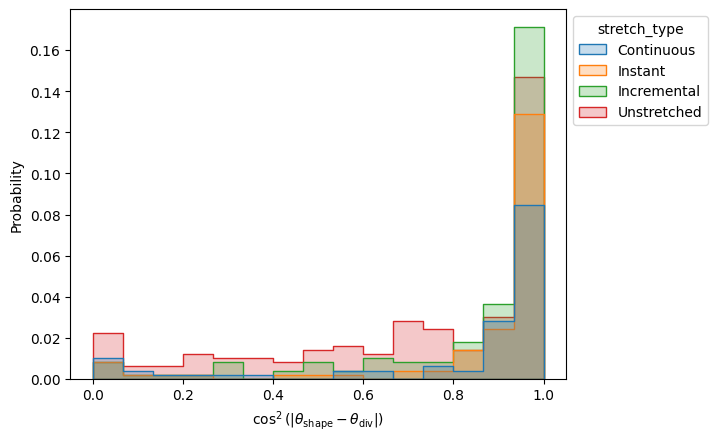

In [339]:
fig, ax=plt.subplots()
g=sns.histplot(div_dat, x='shape_div_alignment', element='step', stat='probability', hue='stretch_type')
#h=ax.get_legend().legend_handles()

new_labels=["Continuous","Instant", "Incremental", "Unstretched"]
for t, l in zip(ax.get_legend().texts, new_labels):
    t.set_text(l)

ax.set_xlabel(r"$\cos^2(|\theta_{\mathrm{shape}}-\theta_{\mathrm{div}}|)$")
sns.move_legend(g, "upper left", bbox_to_anchor=(1,1), frameon=True)

plt.savefig(save_dir+'/division_shape_alignment.png', dpi=300, bbox_inches='tight')

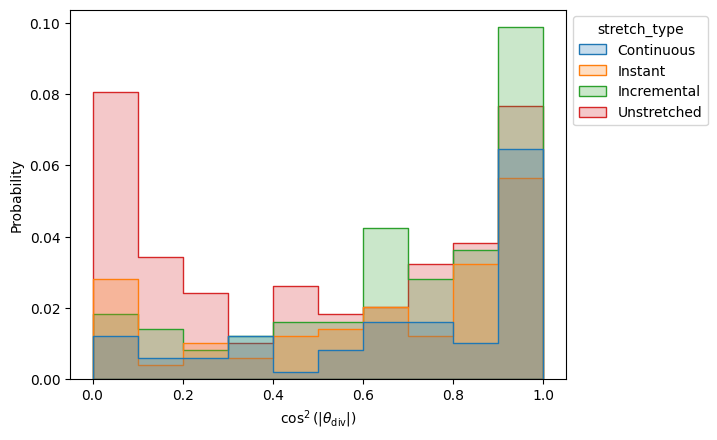

In [340]:
fig, ax=plt.subplots()
g=sns.histplot(div_dat, x='div_stretch_alignment', element='step', stat='probability', hue='stretch_type')
#h=ax.get_legend().legend_handles()

new_labels=["Continuous","Instant", "Incremental", "Unstretched"]
for t, l in zip(ax.get_legend().texts, new_labels):
    t.set_text(l)

ax.set_xlabel(r"$\cos^2(|\theta_{\mathrm{div}}|)$")
sns.move_legend(g, "upper left", bbox_to_anchor=(1,1), frameon=True)

plt.savefig(save_dir+'/division_stretch_alignment.png', dpi=300, bbox_inches='tight')

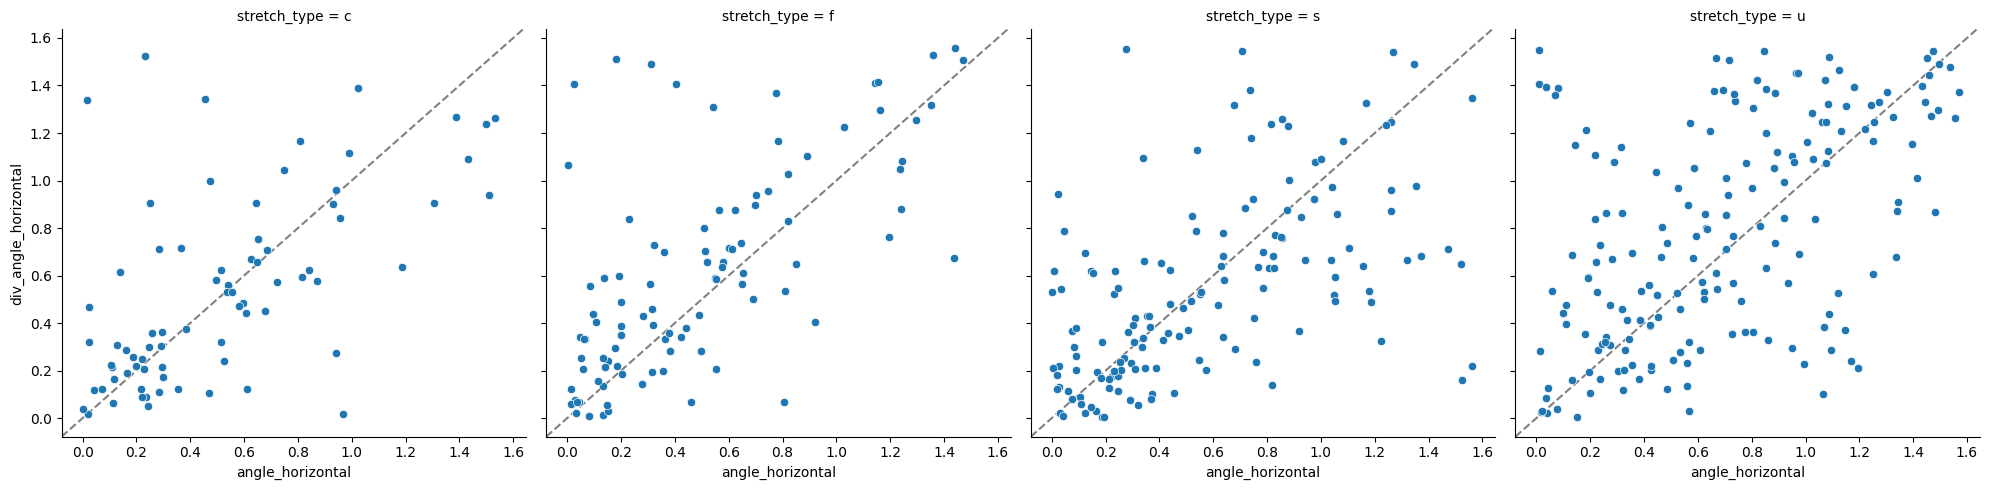

In [349]:
g=sns.relplot(div_dat, x='angle_horizontal',y='div_angle_horizontal', col='stretch_type')
g.map(plt.axline, xy1=(0,0), slope=1, zorder=0, linestyle='--', color='grey')



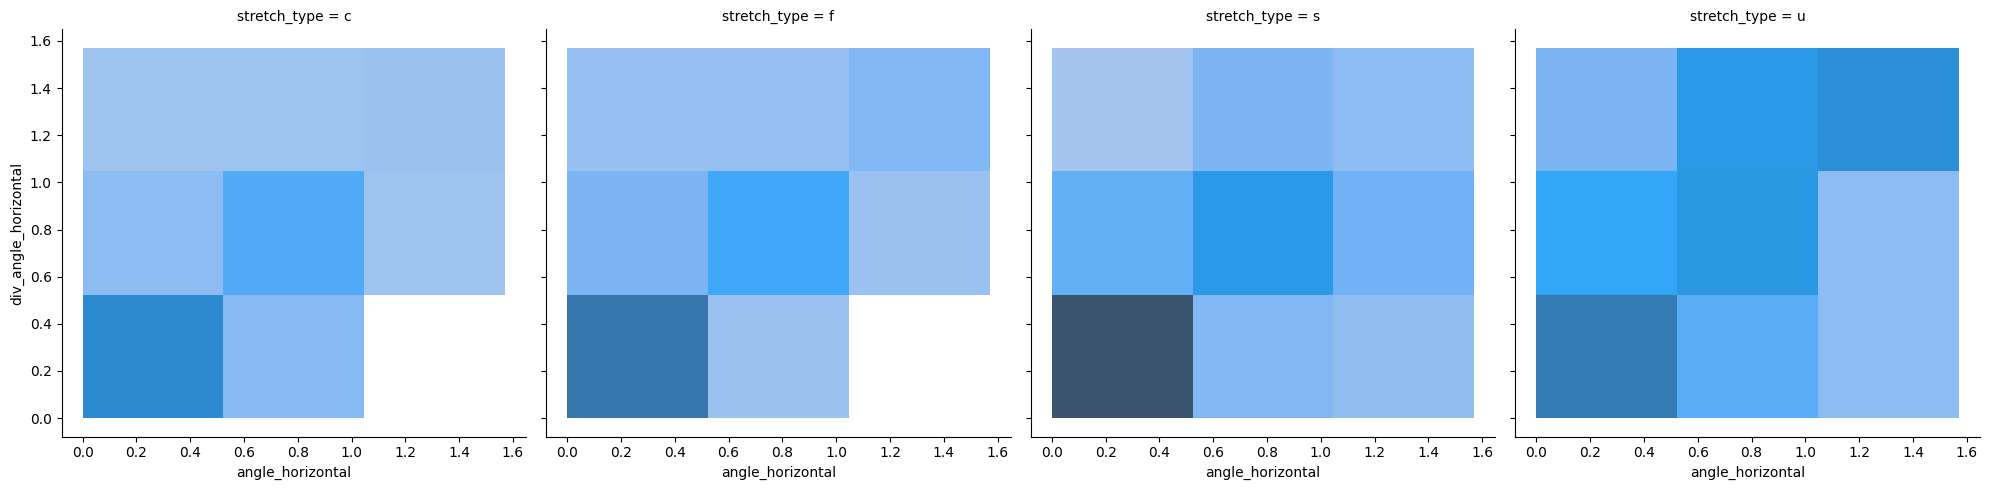

In [350]:
g=sns.displot(div_dat, x='angle_horizontal',y='div_angle_horizontal', col='stretch_type', kind='hist', binrange=(0, np.pi/2), bins=(3,3))

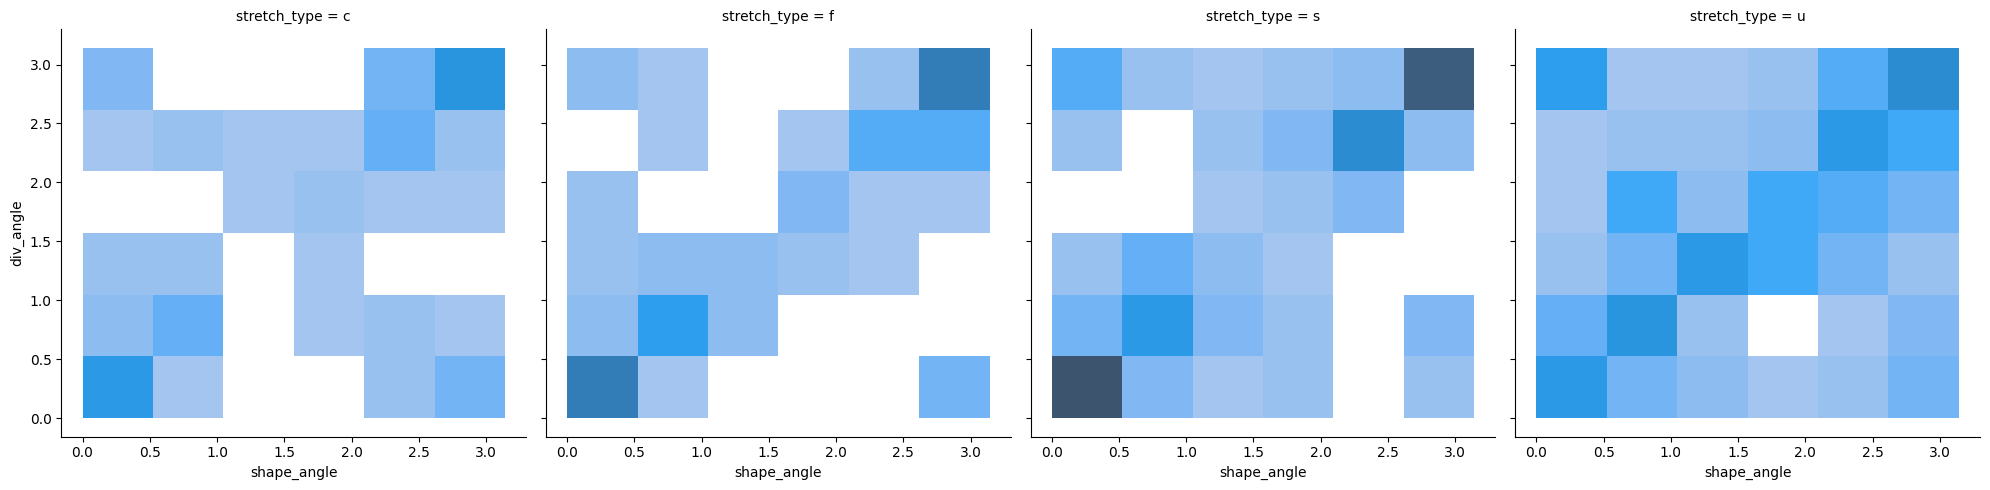

In [351]:
g=sns.displot(div_dat, x='shape_angle',y='div_angle', col='stretch_type', kind='hist', binrange=(0, np.pi), bins=(6,6))

In [362]:
exp_data[['experiment', 'stretch_type', 'experiment_length', 'initial_cell_count', 'initial_total_area', 'number_of_divisions']].to_latex(out_folder+"exp_summary.tex")

C:\Users\v35431nc\AppData\Local\Temp\ipykernel_33796\2101576911.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  exp_data[['experiment', 'stretch_type', 'experiment_length', 'initial_cell_count', 'initial_total_area', 'number_of_divisions']].to_latex(out_folder+"exp_summary.tex")


C:\Users\v35431nc\AppData\Roaming\Python\Python310\site-packages\seaborn\distributions.py:2142: UserWarning: `displot` is a figure-level function and does not accept the ax= parameter. You may wish to try histplot.
  warnings.warn(msg, UserWarning)
C:\Users\v35431nc\AppData\Roaming\Python\Python310\site-packages\seaborn\distributions.py:2142: UserWarning: `displot` is a figure-level function and does not accept the ax= parameter. You may wish to try histplot.
  warnings.warn(msg, UserWarning)


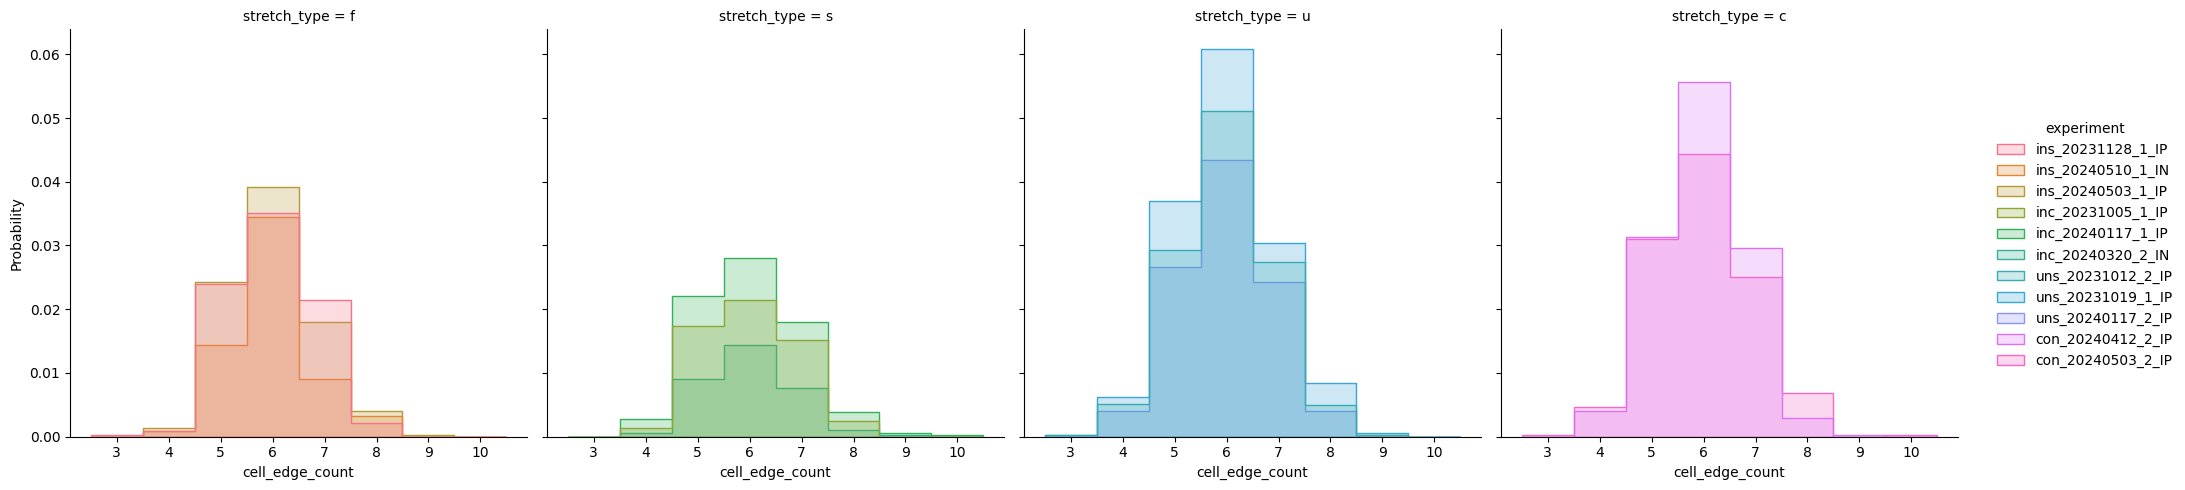

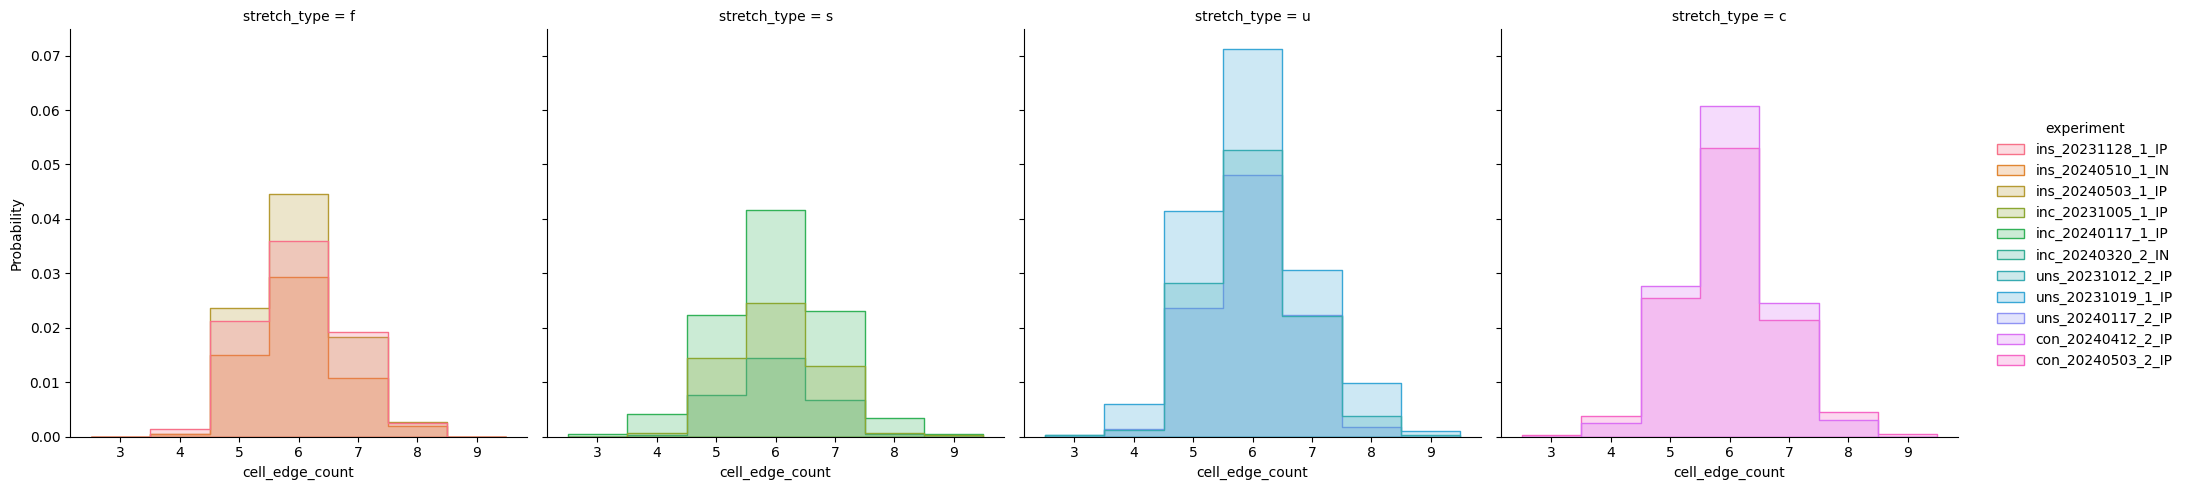

In [379]:
#fig, ax=plt.subplots()
g = sns.displot(
    data=cell_data[cell_data.time==0],ax=ax,  x="cell_edge_count", hue='experiment', col='stretch_type', discrete='true', element='step', stat='probability', multiple='layer')

#fig, ax=plt.subplots()
g = sns.displot(
    data=cell_data[cell_data.time==125],ax=ax,  x="cell_edge_count", hue='experiment', col='stretch_type', discrete='true', element='step', stat='probability', multiple='layer')

C:\Users\v35431nc\AppData\Roaming\Python\Python310\site-packages\seaborn\distributions.py:2142: UserWarning: `displot` is a figure-level function and does not accept the ax= parameter. You may wish to try histplot.
  warnings.warn(msg, UserWarning)
C:\Users\v35431nc\AppData\Roaming\Python\Python310\site-packages\seaborn\distributions.py:2142: UserWarning: `displot` is a figure-level function and does not accept the ax= parameter. You may wish to try histplot.
  warnings.warn(msg, UserWarning)


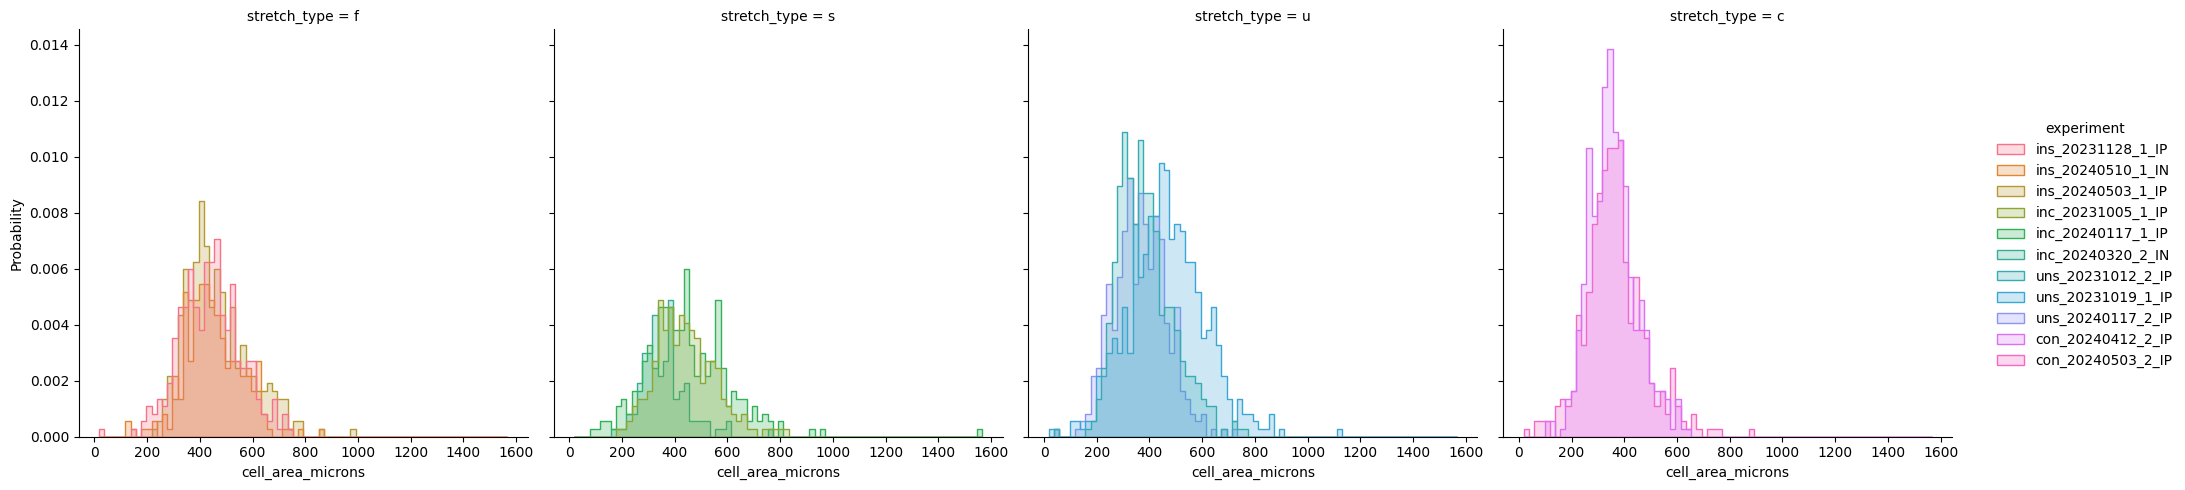

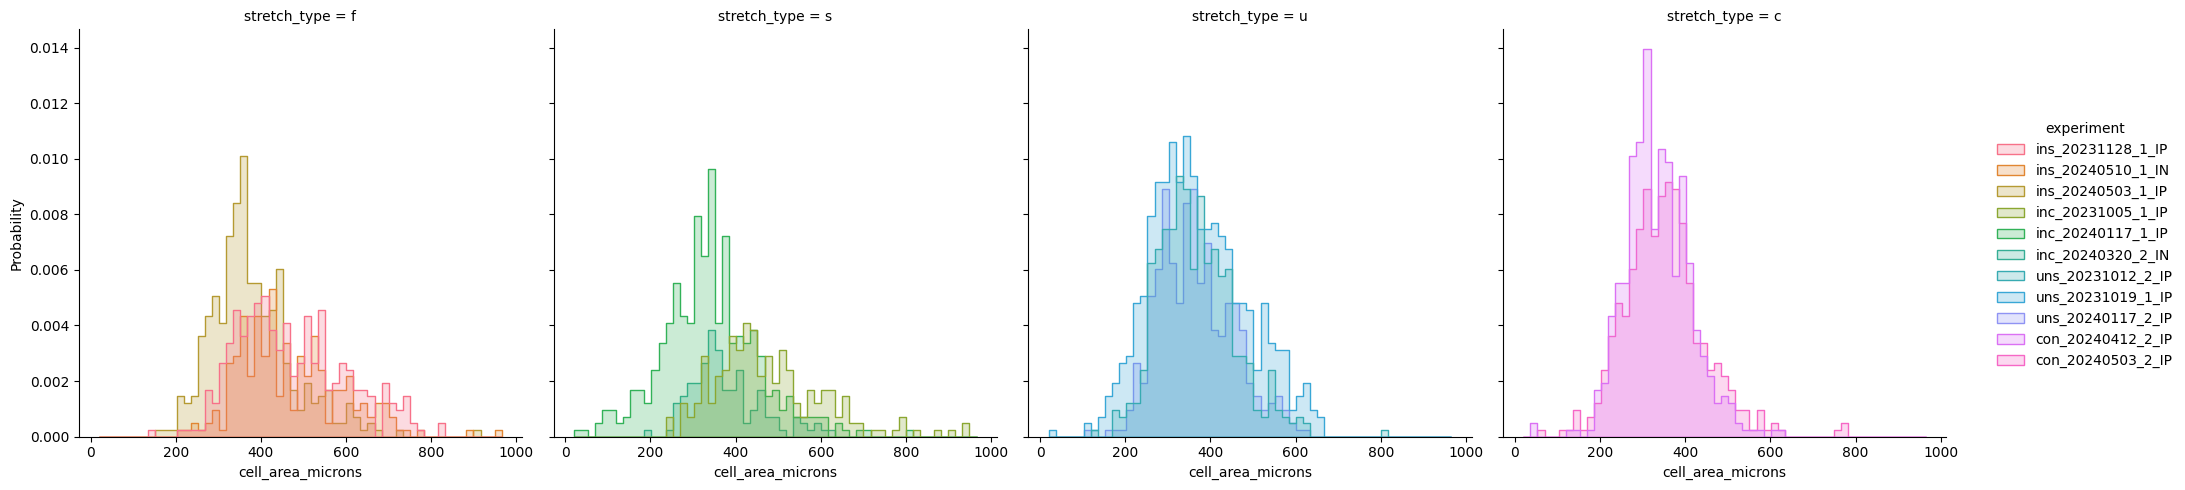

In [378]:
#fig, ax=plt.subplots()
g = sns.displot(
    data=cell_data[cell_data.time==0],ax=ax,  x="cell_area_microns", hue='experiment', col='stretch_type', element='step', stat='probability', multiple='layer')

#fig, ax=plt.subplots()
g = sns.displot(
    data=cell_data[cell_data.time==125],ax=ax,  x="cell_area_microns", hue='experiment', col='stretch_type', element='step', stat='probability', multiple='layer')

AttributeError: Rectangle.set() got an unexpected keyword argument 'stat'

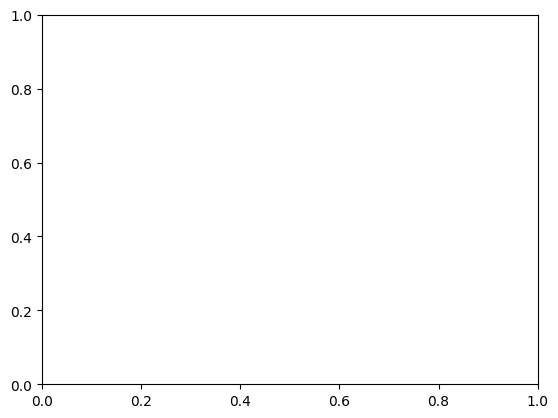

In [383]:
sns.countplot(data=cell_data[cell_data.time==0],x='cell_edge_count', hue='experiment',stat='proportion')
